# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = int(60 / 5) * 4 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.9891 # 1-(60/5*24)/50977 
MODE_TRAIN_AE = False
MODE_AUTO_SELECT = 2  # 0: False, 1: True, 2: from disk
MODE_TRAIN_LSTM = False
MODE_TRAIN_PREDICTOR = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

48

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_94625/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53273  1688513100000   1938.11   1939.75  1938.11    1938.67    278.6432   
53274  1688513400000   1938.68   1939.97  1938.67    1939.88    271.2009   
53275  1688513700000   1939.88   1939.99  1939.62    1939.89    230.5695   
53276  1688514000000   1939.89   1939.90  1939.00    1939.01    195.4143   
53277  1688514300000   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00        1940.21750       1944.555000   
53274  2023-07-04 23:30:00        1940.03500       1944.555000   
53275  2023-07-04 23:35:00        1939.51250       1943.190000   
53276  2023-07-04 23:40:00        1939.23000       1943.140000   
53277  2023-07-04 23:45:00        1938.80250       1943.140000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
53273        1939.735  ...   NaN         NaN            NaN           NaN   
53274        1939.735  ...   NaN         NaN            NaN           NaN   
53275        1939.735  ...   NaN         NaN            NaN           NaN   
53276        1939.735  ...   NaN         NaN            NaN           NaN   
53277        1939.735  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53273               NaN         0.0               NaN         0.0      0.0   
53274               NaN         0.0               NaN         0.0      0.0   
53275               NaN         0.0               NaN         0.0      0.0   
53276               NaN         0.0               NaN         0.0      0.0   
53277               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
53273   NaN  
53274   NaN  
53275   NaN  
53276   NaN  
53277   NaN  

[53278 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53273  1688513100000   1938.11   1939.75  1938.11    1938.67    278.6432   
53274  1688513400000   1938.68   1939.97  1938.67    1939.88    271.2009   
53275  1688513700000   1939.88   1939.99  1939.62    1939.89    230.5695   
53276  1688514000000   1939.89   1939.90  1939.00    1939.01    195.4143   
53277  1688514300000   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00        1940.21750       1944.555000   
53274  2023-07-04 23:30:00        1940.03500       1944.555000   
53275  2023-07-04 23:35:00        1939.51250       1943.190000   
53276  2023-07-04 23:40:00        1939.23000       1943.140000   
53277  2023-07-04 23:45:00        1938.80250       1943.140000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
53273        1939.735  ...   NaN         NaN            NaN           NaN   
53274        1939.735  ...   NaN         NaN            NaN           NaN   
53275        1939.735  ...   NaN         NaN            NaN           NaN   
53276        1939.735  ...   NaN         NaN            NaN           NaN   
53277        1939.735  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53273               NaN         0.0               NaN         0.0      0.0   
53274               NaN         0.0               NaN         0.0      0.0   
53275               NaN         0.0               NaN         0.0      0.0   
53276               NaN         0.0               NaN         0.0      0.0   
53277               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
53273                  NaN  
53274                  NaN  
53275                  NaN  
53276                  NaN  
53277                  NaN  

[53278 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       225
delta_event_real    225
delta_event_pred    225
Previous_num        225
Actual_num          225
Event               225
Date                225
Previous            225
Consensus           225
Actual              225
Country             225
Time (ET)           225
keep                225
date                225
dtype: int64

on 53278 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
53273   1938.11   1939.75  1938.11    1938.67    278.6432   
53274   1938.68   1939.97  1938.67    1939.88    271.2009   
53275   1939.88   1939.99  1939.62    1939.89    230.5695   
53276   1939.89   1939.90  1939.00    1939.01    195.4143   
53277   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00        1940.21750       1944.555000   
53274  2023-07-04 23:30:00        1940.03500       1944.555000   
53275  2023-07-04 23:35:00        1939.51250       1943.190000   
53276  2023-07-04 23:40:00        1939.23000       1943.140000   
53277  2023-07-04 23:45:00        1938.80250       1943.140000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710          1194.71  ...  1196.096667  1196.096667   
1            1194.710          1194.71  ...  1195.801420  1195.801420   
2            1194.710          1194.71  ...  1195.648641  1195.648641   
3            1194.710          1194.71  ...  1195.575250  1195.575250   
4            1194.710          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
53273        1939.735          1939.61  ...  1869.364719  1831.534886   
53274        1939.735          1939.61  ...  1869.381399  1831.537236   
53275        1939.735          1939.61  ...  1869.397347  1831.539467   
53276        1939.735          1939.39  ...  1869.426275  1831.541753   
53277        1939.735          1939.03  ...  1869.435788  1831.543394   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
53273  1858.935516  1827.411232   1718.544368          1.192113  0.113545   
53274  1858.937301  1827.404362   1718.545073          1.198658  0.114097   
53275  1858.938977  1827.400312   1718.545673          1.198705  0.114101   
53276  1858.940228  1827.394577   1718.546180          1.193933  0.113699   
53277  1858.942251  1827.387487   1718.546358          1.196961  0.113955   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.871741  
1      1.205254e+08      522461.0       17.871741  
2      1.205254e+08      522461.0       17.871741  
3      1.205254e+08      522461.0       17.871741  
4      1.205254e+08      522461.0       17.871741  
...             ...           ...             ...  
53273  1.202171e+08      493544.0       19.007661  
53274  1.202171e+08      493544.0       19.007661  
53275  1.202171e+08      493544.0       19.007661  
53276  1.202171e+08      493544.0       19.007661  
53277  1.202171e+08      493544.0       19.007661  

[53278 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [21]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [22]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [23]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [24]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [25]:
df_feat.shape[0]

53278

In [26]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

52697

In [27]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53273  1688513100000   1938.11   1939.75  1938.11    1938.67    278.6432   
53274  1688513400000   1938.68   1939.97  1938.67    1939.88    271.2009   
53275  1688513700000   1939.88   1939.99  1939.62    1939.89    230.5695   
53276  1688514000000   1939.89   1939.90  1939.00    1939.01    195.4143   
53277  1688514300000   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00        1940.21750       1944.555000   
53274  2023-07-04 23:30:00        1940.03500       1944.555000   
53275  2023-07-04 23:35:00        1939.51250       1943.190000   
53276  2023-07-04 23:40:00        1939.23000       1943.140000   
53277  2023-07-04 23:45:00        1938.80250       1943.140000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53273        1939.735  ...         NaN            NaN           NaN   
53274        1939.735  ...         NaN            NaN           NaN   
53275        1939.735  ...         NaN            NaN           NaN   
53276        1939.735  ...         NaN            NaN           NaN   
53277        1939.735  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53273               NaN         0.0               NaN         0.0      0.0   
53274               NaN         0.0               NaN         0.0      0.0   
53275               NaN         0.0               NaN         0.0      0.0   
53276               NaN         0.0               NaN         0.0      0.0   
53277               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53273                  NaN  False  
53274                  NaN  False  
53275                  NaN  False  
53276                  NaN  False  
53277                  NaN  False  

[53278 rows x 136 columns]

In [28]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
52693  1688339100000   1939.76   1941.28  1934.18    1939.40   3030.9404   
52694  1688339400000   1939.40   1942.00  1939.39    1940.76    626.8558   
52695  1688339700000   1940.75   1941.39  1935.00    1935.57   1088.8998   
52696  1688340000000   1935.57   1936.35  1932.19    1933.10   1252.0539   
52697  1688340300000   1933.10   1937.34  1933.07    1937.21    817.4904   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
52693  2023-07-02 23:05:00        1915.82250       1911.000000   
52694  2023-07-02 23:10:00        1917.02750       1911.765000   
52695  2023-07-02 23:15:00        1917.11250       1911.765000   
52696  2023-07-02 23:20:00        1917.16250       1911.765000   
52697  2023-07-02 23:25:00        1917.35500       1911.765000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
52693         1935.74  ...         0.0            0.0           0.0   
52694         1935.74  ...         0.0            0.0           0.0   
52695         1935.74  ...         0.0            0.0           0.0   
52696         1935.74  ...         0.0            0.0           0.0   
52697         1935.74  ...         0.0            0.0           0.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
52693               0.0         0.0               0.0         0.0      0.0   
52694               0.0         0.0               0.0         0.0      0.0   
52695               0.0         0.0               0.0         0.0      0.0   
52696               0.0         0.0               0.0         0.0      0.0   
52697               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
52693  2023-07-03 05:00:00   True  
52694  2023-07-03 05:00:00   True  
52695  2023-07-03 05:00:00   True  
52696  2023-07-03 05:00:00   True  
52697  2023-07-03 05:00:00   True  

[52698 rows x 136 columns]

In [29]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
52698  1688340600000   1937.21   1939.19  1933.86    1935.11   1133.9657   
52699  1688340900000   1935.12   1935.12  1932.96    1933.28    569.1120   
52700  1688341200000   1933.28   1935.22  1933.28    1934.83    777.2381   
52701  1688341500000   1934.82   1934.94  1930.61    1931.63   1186.2440   
52702  1688341800000   1931.63   1940.00  1931.44    1937.02   2614.3213   
...              ...       ...       ...      ...        ...         ...   
53273  1688513100000   1938.11   1939.75  1938.11    1938.67    278.6432   
53274  1688513400000   1938.68   1939.97  1938.67    1939.88    271.2009   
53275  1688513700000   1939.88   1939.99  1939.62    1939.89    230.5695   
53276  1688514000000   1939.89   1939.90  1939.00    1939.01    195.4143   
53277  1688514300000   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
52698  2023-07-02 23:30:00         1918.0000          1912.040   
52699  2023-07-02 23:35:00         1919.3675          1913.295   
52700  2023-07-02 23:40:00         1919.5550          1913.295   
52701  2023-07-02 23:45:00         1919.5550          1913.295   
52702  2023-07-02 23:50:00         1919.7625          1913.295   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00         1940.2175          1944.555   
53274  2023-07-04 23:30:00         1940.0350          1944.555   
53275  2023-07-04 23:35:00         1939.5125          1943.190   
53276  2023-07-04 23:40:00         1939.2300          1943.140   
53277  2023-07-04 23:45:00         1938.8025          1943.140   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
52698        1935.740  ...         0.0            0.0           0.0   
52699        1935.740  ...         0.0            0.0           0.0   
52700        1935.740  ...         0.0            0.0           0.0   
52701        1935.740  ...         0.0            0.0           0.0   
52702        1935.740  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53273        1939.735  ...         NaN            NaN           NaN   
53274        1939.735  ...         NaN            NaN           NaN   
53275        1939.735  ...         NaN            NaN           NaN   
53276        1939.735  ...         NaN            NaN           NaN   
53277        1939.735  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
52698               0.0         0.0               0.0         0.0      0.0   
52699               0.0         0.0               0.0         0.0      0.0   
52700               0.0         0.0               0.0         0.0      0.0   
52701               0.0         0.0               0.0         0.0      0.0   
52702               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53273               NaN         0.0               NaN         0.0      0.0   
53274               NaN         0.0               NaN         0.0      0.0   
53275               NaN         0.0               NaN         0.0      0.0   
53276               NaN         0.0               NaN         0.0      0.0   
53277               NaN         0.0               NaN         0.0      0.0   

                      date  train  
52698  2023-07-03 05:00:00  False  
52699  2023-07-03 05:00:00  False  
52700  2023-07-03 05:00:00  False  
52701  2023-07-03 05:00:00  False  
52702  2023-07-03 05:00:00  False  
...                    ...    ...  
53273                  NaN  False  
53274                  NaN  False  
53275                  NaN  False  
53276                  NaN  False  
53277                  NaN  False  

[580 rows x 136 columns]

In [30]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [31]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [32]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [33]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52635, 48, 104) (52635, 15)
(517, 48, 104) (517, 15)


In [34]:
X_train

array([[[1.00190948, 1.00175036, 1.00190948, ..., 0.        ,
         0.        , 0.        ],
        [1.00112224, 1.00190111, 1.00221936, ..., 0.        ,
         0.        , 0.        ],
        [1.00042712, 1.00112224, 1.00148236, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.        , 0.9999665 , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [1.00029312, 0.99999163, 1.00029312, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.00028475, 1.00029312, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00133189, 1.00211092, 1.00242924, ..., 0.        ,
         0.        , 0.        ],
        [1.00063663, 1.00133189, 1.00169209, ..., 0.        ,
         0.        , 0.        ],
        [1.00183449, 1.00063663, 1.00183449, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.0005026 , 1.00020104, 1.0005026 , ..., 0.        ,
         0.        , 0.        ],
        [1.0

In [35]:
seq_y

array([0.99968304, 1.00455689, 1.00792909, 1.01313547, 1.01695452,
       1.01546847, 1.00510766, 1.00625078, 1.00922808, 1.00908779,
       1.00789271, 1.00771085, 1.00841751, 1.00572079, 1.00443738])

In [36]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [1.00100989, 1.0018532 , 1.00153566, ..., 1.00976054, 1.00957834,
        1.01028631],
       [1.00084246, 1.00052524, 1.00540318, ..., 1.00855981, 1.00926706,
        1.00656807],
       [0.99968304, 1.00455689, 1.00792909, ..., 1.00841751, 1.00572079,
        1.00443738]])

In [37]:
seq_y

array([0.99968304, 1.00455689, 1.00792909, 1.01313547, 1.01695452,
       1.01546847, 1.00510766, 1.00625078, 1.00922808, 1.00908779,
       1.00789271, 1.00771085, 1.00841751, 1.00572079, 1.00443738])

In [38]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [1.00100989, 1.0018532 , 1.00153566, ..., 1.00976054, 1.00957834,
        1.01028631],
       [1.00084246, 1.00052524, 1.00540318, ..., 1.00855981, 1.00926706,
        1.00656807],
       [0.99968304, 1.00455689, 1.00792909, ..., 1.00841751, 1.00572079,
        1.00443738]])

In [39]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [40]:
X_train.shape

(52635, 48, 104)

In [41]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(52635, 48, 104) (52635, 15)
(517, 48, 104) (517, 15)


## Standardization

In [42]:
if MODE_TRAIN_PREDICTOR:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [43]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [1.00100989, 1.0018532 , 1.00153566, ..., 1.00976054, 1.00957834,
        1.01028631],
       [1.00084246, 1.00052524, 1.00540318, ..., 1.00855981, 1.00926706,
        1.00656807],
       [0.99968304, 1.00455689, 1.00792909, ..., 1.00841751, 1.00572079,
        1.00443738]])

In [44]:
np.mean(y_train_sca)

0.0003990884164342783

In [45]:
np.std(y_train_sca)

1.0002651871546948

In [46]:
np.mean(y_test_sca)

-0.03466888511734626

In [47]:
np.std(y_test_sca)

0.518050199054492

### Check unscaling

In [48]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65        1726.48712       1725.824627   
1    1195.38   1196.31   1196.69  1194.90        1726.48712       1725.824627   
2    1194.55   1195.38   1195.81  1194.55        1726.48712       1725.824627   
3    1195.98   1194.55   1195.98  1194.31        1726.48712       1725.824627   
4    1196.06   1195.98   1196.37  1195.97        1726.48712       1725.824627   
5    1196.61   1196.06   1196.70  1196.06        1726.48712       1725.824627   
6    1194.36   1196.62   1196.62  1193.72        1726.48712       1725.824627   
7    1194.22   1194.37   1194.43  1192.72        1726.48712       1725.824627   
8    1193.64   1194.22   1194.22  1193.02        1726.48712       1725.824627   
9    1194.64   1193.64   1195.06  1193.63        1726.48712       1725.824627   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1729.594765   
1         1194.71          1194.71           1729.594765   
2         1194.71          1194.71           1729.594765   
3         1194.71          1194.71           1729.594765   
4         1194.71          1194.71           1729.594765   
5         1194.71          1194.71           1729.594765   
6         1194.71          1194.71           1729.594765   
7         1194.71          1194.71           1729.594765   
8         1194.71          1194.71           1729.594765   
9         1194.71          1194.71           1729.594765   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0           1717.513672  ...       0.0      0.62349    -0.781831   
1           1717.513672  ...       0.0      0.62349    -0.781831   
2           1717.513672  ...       0.0      0.62349    -0.781831   
3           1717.513672  ...       0.0      0.62349    -0.781831   
4           1717.513672  ...       0.0      0.62349    -0.781831   
5           1717.513672  ...       0.0      0.62349    -0.781831   
6           1717.513672  ...       0.0      0.62349    -0.781831   
7           1717.513672  ...       0.0      0.62349    -0.781831   
8           1717.513672  ...       0.0      0.62349    -0.781831   
9           1717.513672  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [49]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [50]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [52]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [53]:
X_train_sca.shape

(52635, 48, 104)

In [54]:
X_train_sca[:,-1,:].shape

(52635, 104)

In [55]:
y_train_sca[:,0][:, np.newaxis]

array([[-0.06617876],
       [-0.20703854],
       [-0.04908362],
       ...,
       [ 0.21086617],
       [ 0.17282205],
       [-0.09062396]])

In [56]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(52635, 105)

In [57]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [58]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [59]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

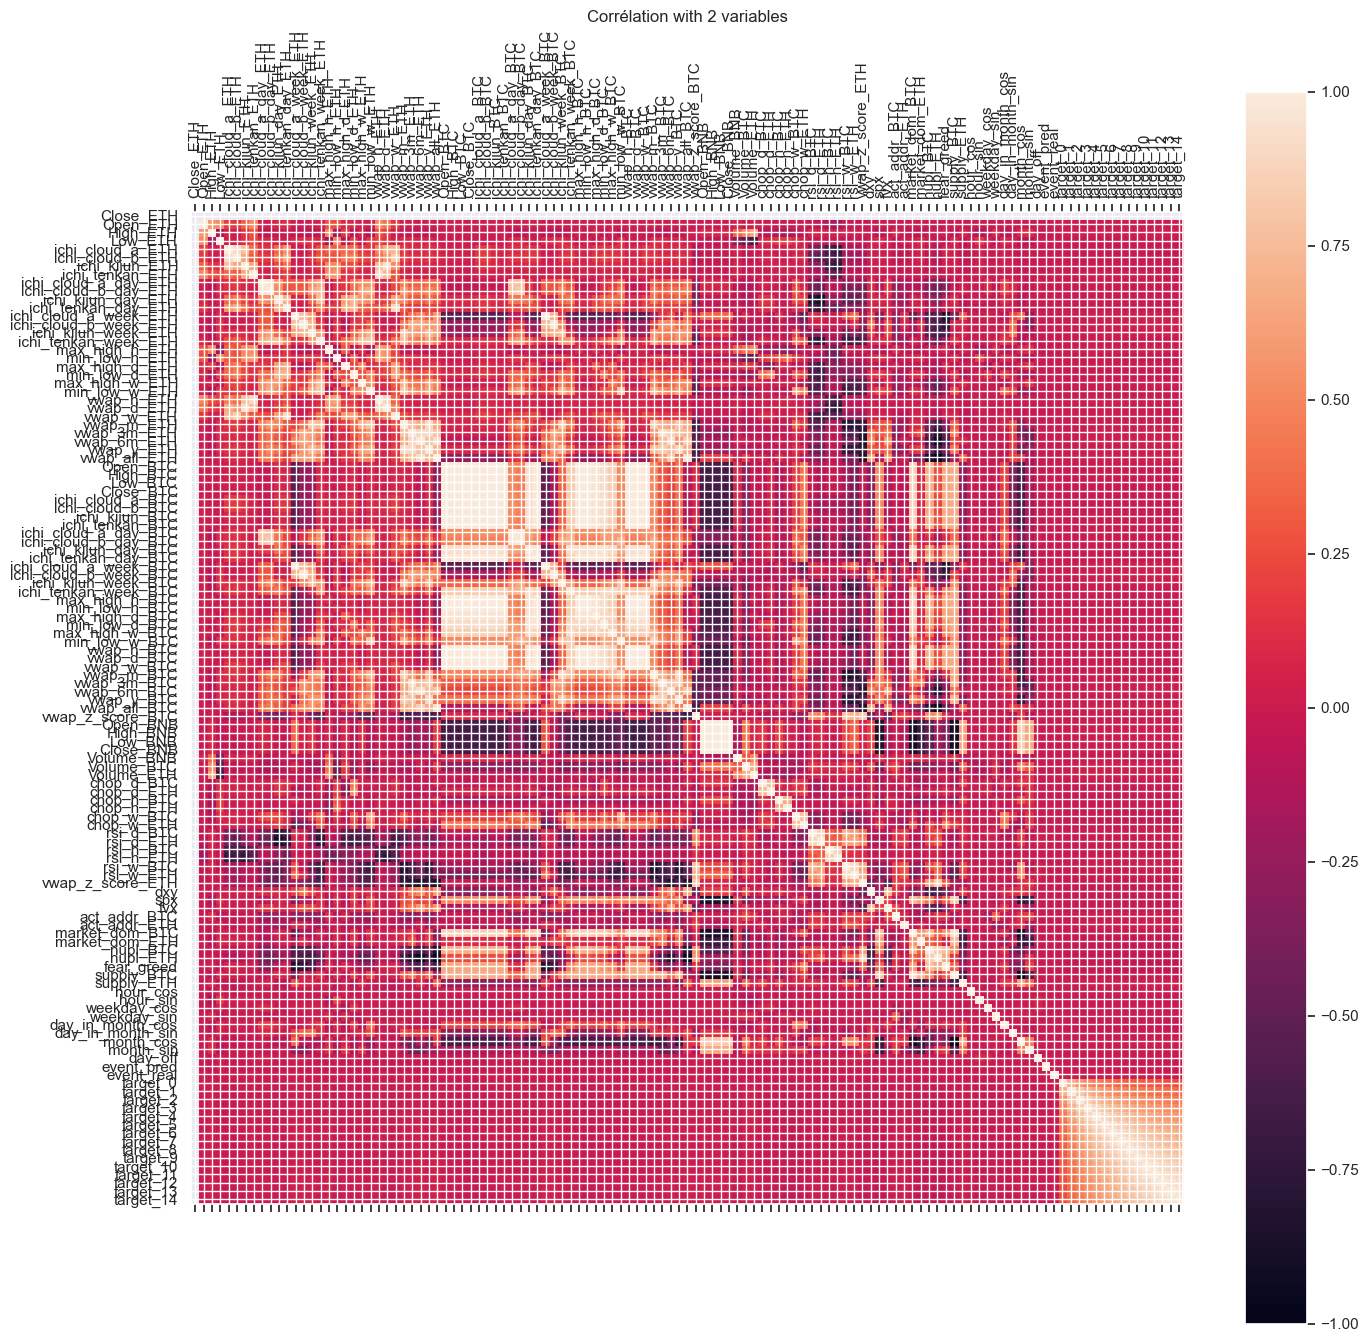

In [60]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


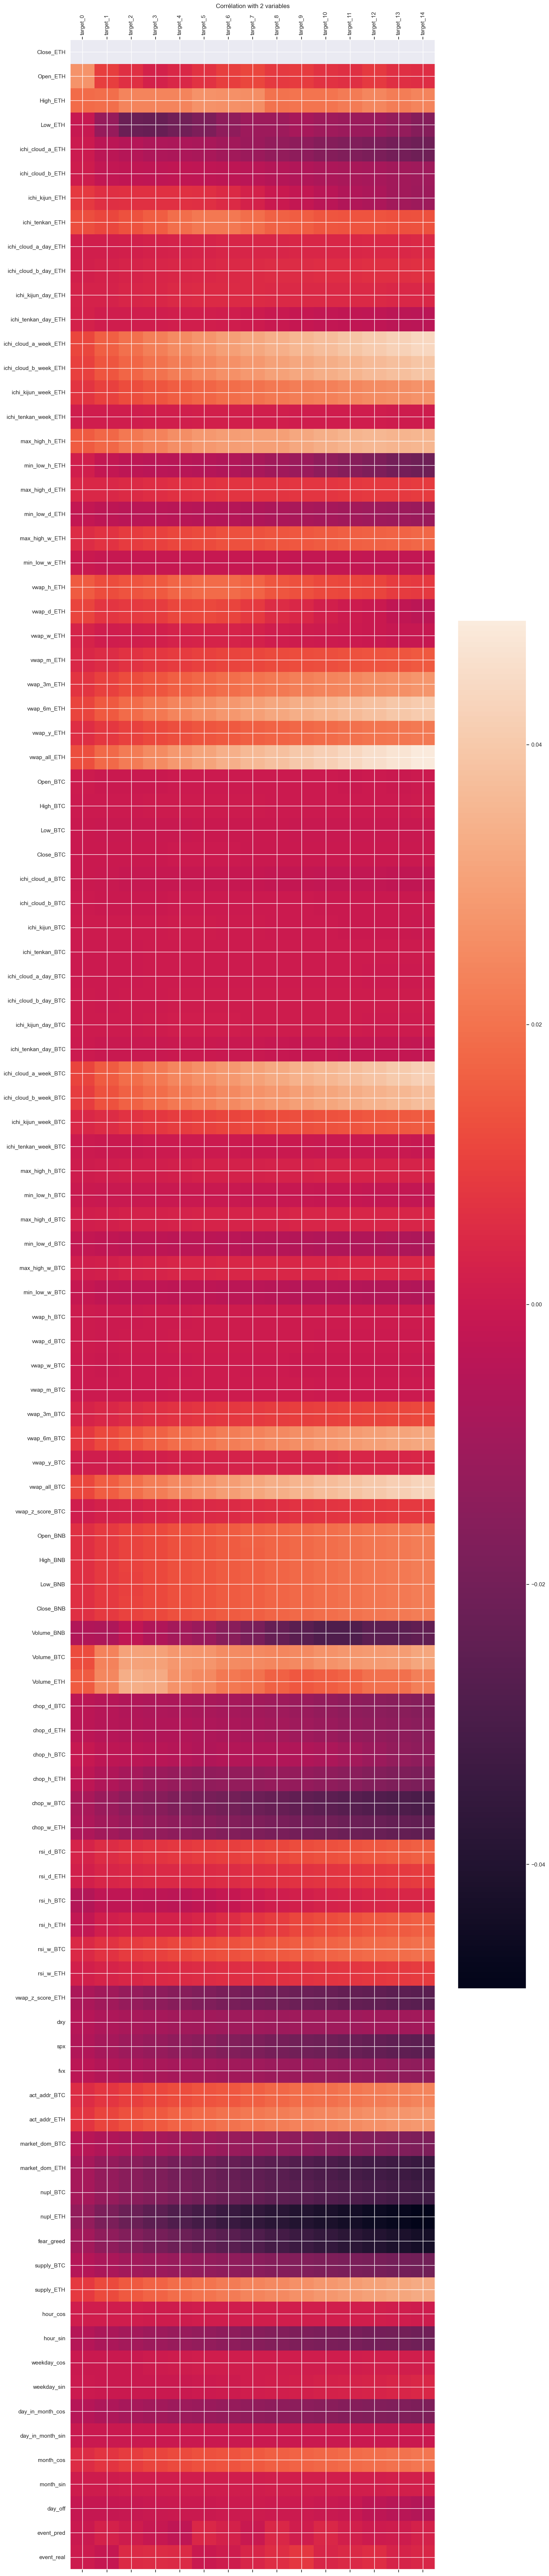

In [61]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


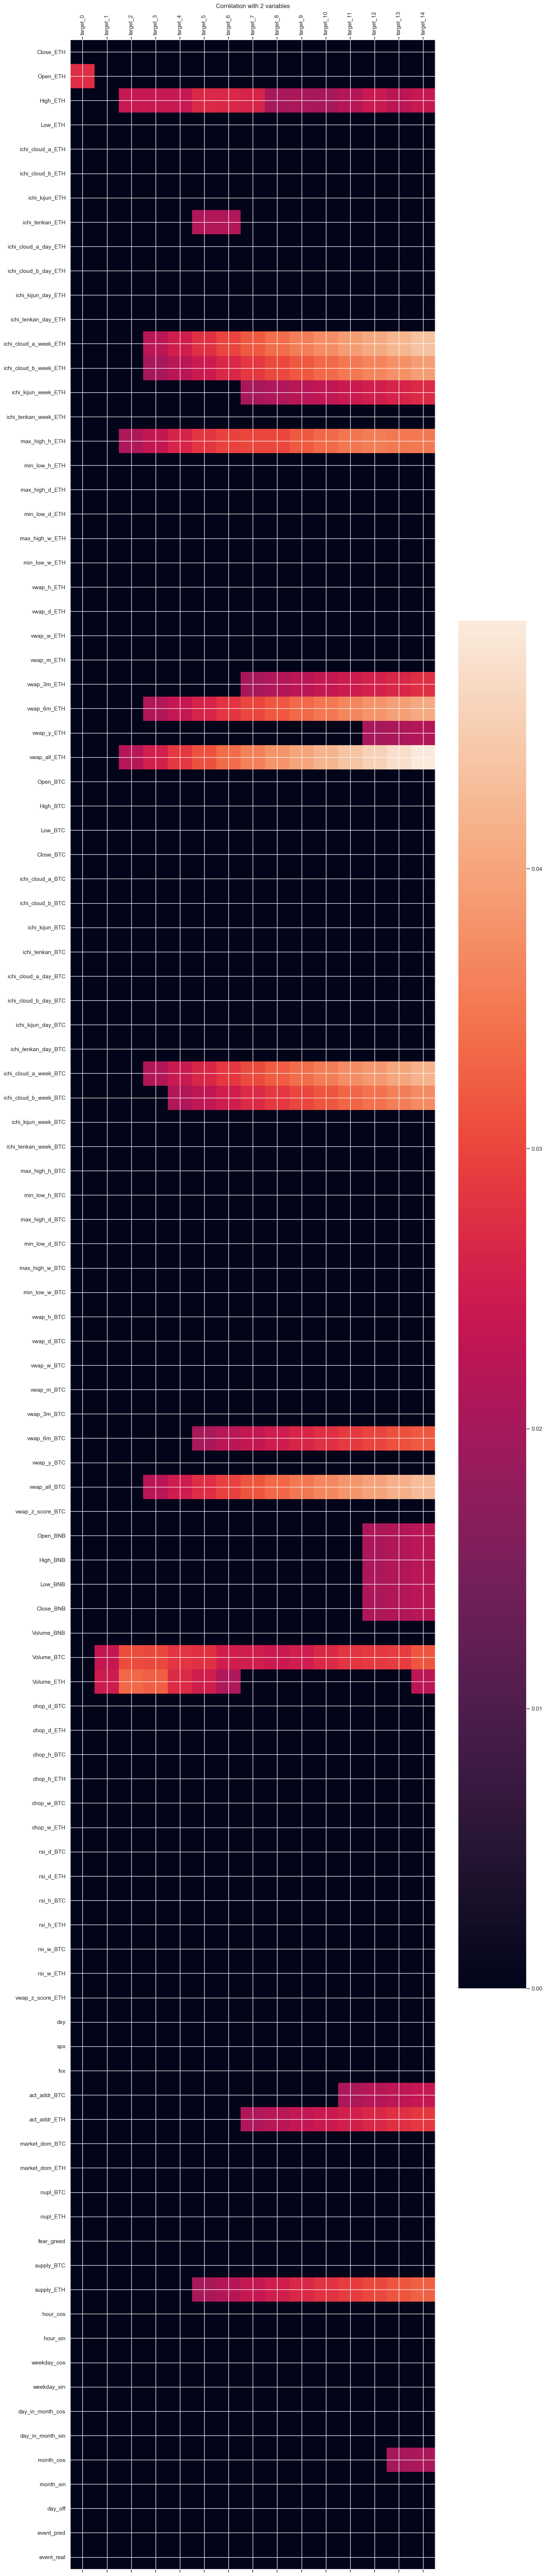

In [62]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [63]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

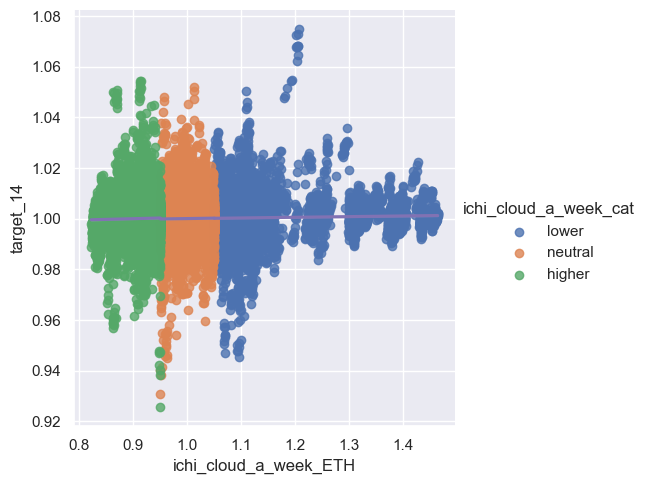

In [64]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

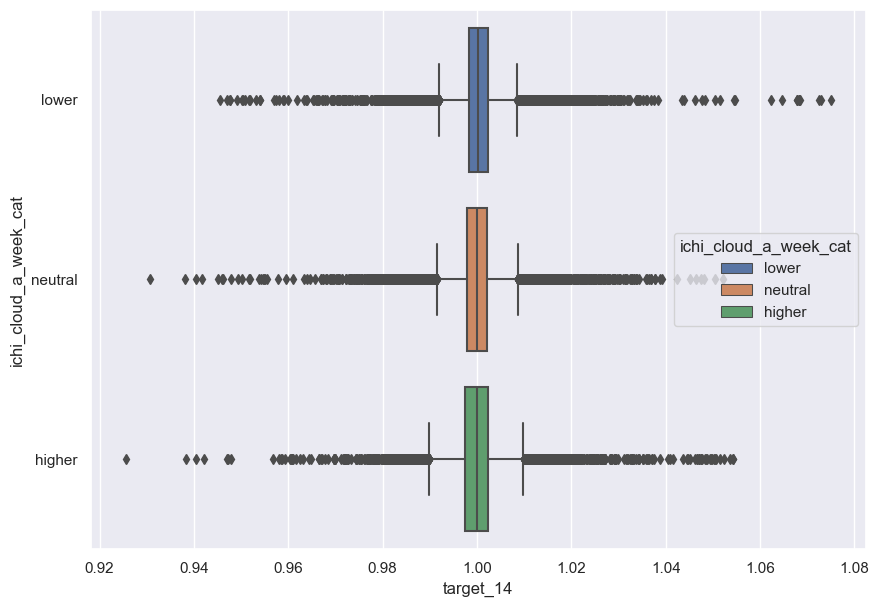

In [65]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [66]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


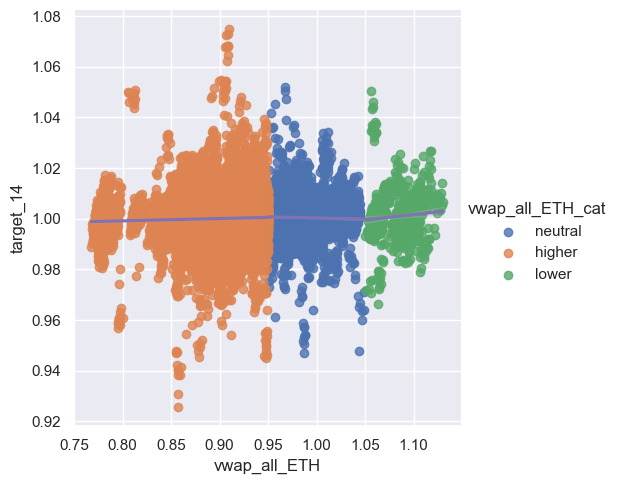

In [67]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

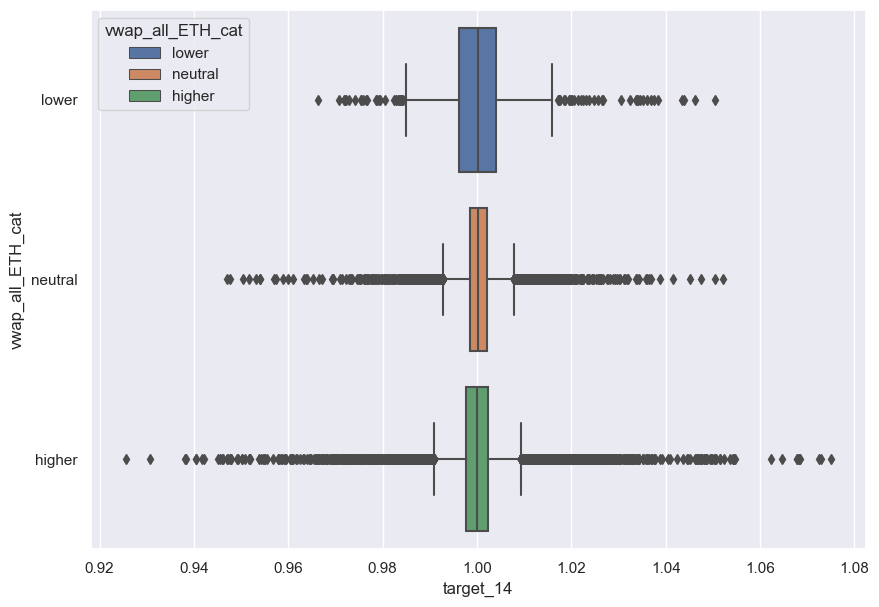

In [68]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

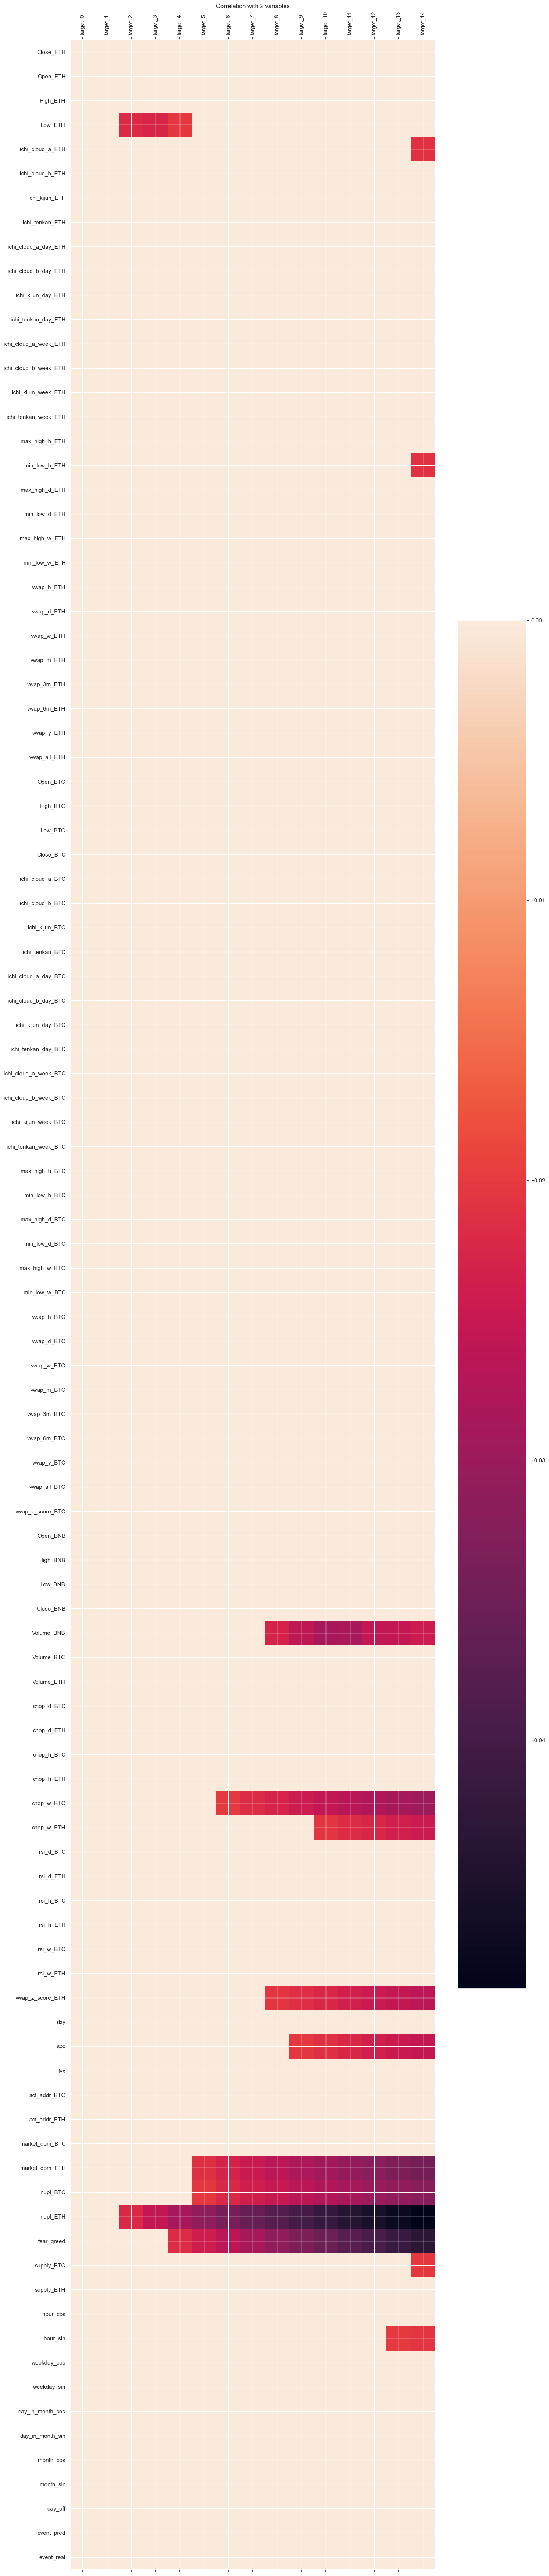

In [69]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

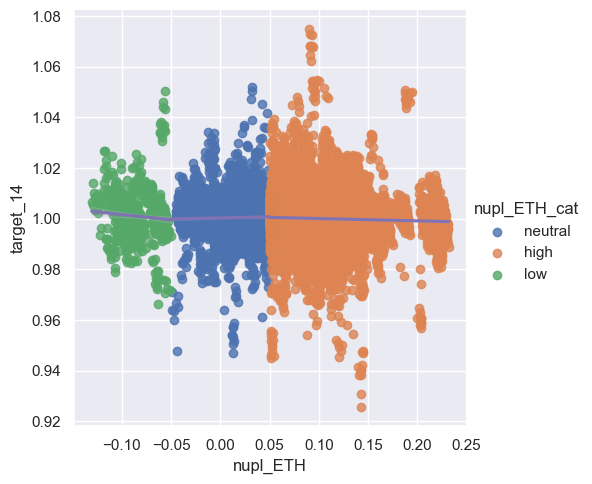

In [70]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

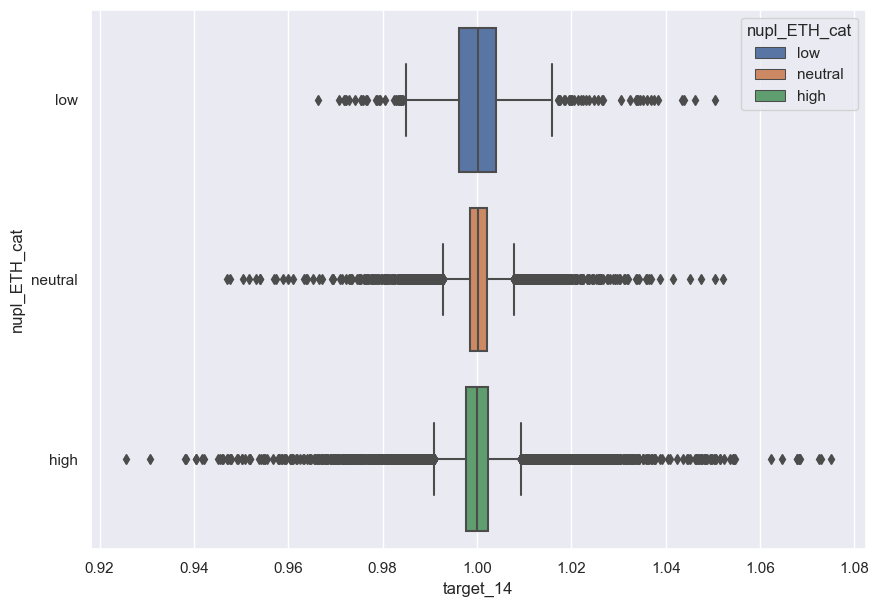

In [71]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [72]:
df["target_14"].describe()

count    52635.000000
mean         1.000157
std          0.006008
min          0.925613
25%          0.997894
50%          1.000049
75%          1.002306
max          1.074927
Name: target_14, dtype: float64

In [73]:
df["target_1"].describe()

count    52635.000000
mean         1.000021
std          0.002204
min          0.967271
25%          0.999170
50%          1.000011
75%          1.000858
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

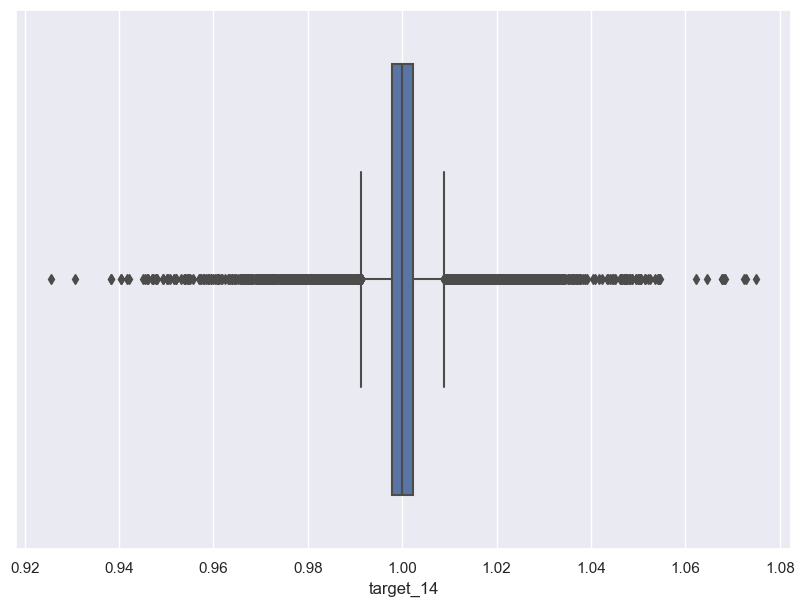

In [74]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [75]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [1.00100989, 1.0018532 , 1.00153566, ..., 1.00976054, 1.00957834,
        1.01028631],
       [1.00084246, 1.00052524, 1.00540318, ..., 1.00855981, 1.00926706,
        1.00656807],
       [0.99968304, 1.00455689, 1.00792909, ..., 1.00841751, 1.00572079,
        1.00443738]])

In [76]:
y_train_sca

array([[-0.06617876, -0.25457352, -0.28502116, ..., -0.14990977,
        -0.18796932, -0.16132763],
       [-0.20703854, -0.23749256, -0.26223644, ..., -0.14042039,
        -0.11377312, -0.12138663],
       [-0.04908362, -0.07384804, -0.13671158, ...,  0.0747385 ,
         0.06711868,  0.12807726],
       ...,
       [ 0.21086617,  0.40248587,  0.33033278, ...,  2.19921625,
         2.15781693,  2.31868285],
       [ 0.17282205,  0.10074175,  1.20912411, ...,  1.92638221,
         2.08708583,  1.47381243],
       [-0.09062396,  1.01682542,  1.78306705, ...,  1.89404812,
         1.28129095,  0.98967048]])

## Autoencoder

In [77]:
X_train.shape

(52635, 48, 104)

### Model creation

### Training

In [78]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 30 #100 #150 #6 #300
patience = 0 #20 #40 #3 #100
for n_unit_enc in [128]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.05]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            path_jpg = os.path.join(path_data,
                f"output_MSE autoencoder - {plt_name}.jpg")
            if os.path.exists(path_jpg) | (MODE_TRAIN_AE == False):
                print(f"BE CAREFUL ! : {path_jpg} exists or training inactivated => no training done...")
                continue
            print(f"Training: {plt_name} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - {plt_name}",
                saveFolder=path_data)
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")

if MODE_TRAIN_AE:
    print("Save models...")
    autoencoder.save(path_mdl_autoencoder)
    encoder_model.save(path_mdl_encoder)
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())


BE CAREFUL ! : data/output_MSE autoencoder - TS 0.9891 - units 128 - enc_dim 32 - drop 0.05.jpg exists or training inactivated => no training done...
Load models...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 model (Functional)          (None, None, 32)          123424    
                                                                 
 model_1 (Functional)        (None, None, 104)         95848     
                                                                 
Total params: 219,272
Trainable params: 219,272
Non-trainable params: 0
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (Non

### Save model

In [79]:
# TODO select best model


In [80]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [81]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [82]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-07-05 08:50:20.741730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1645/1645 [==============================] - 30s 18ms/step


(52635, 48, 104)

### Results

In [83]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

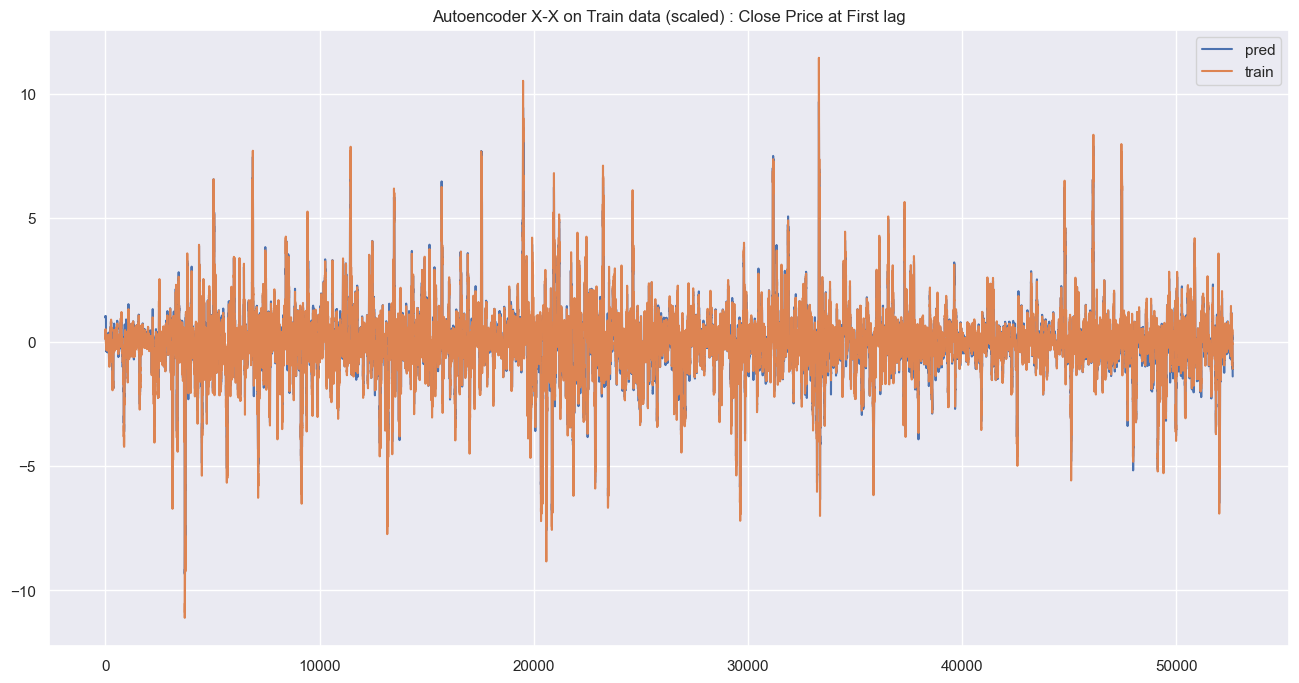

In [84]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [85]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(52635, 48, 104)
(52635, 48, 104)
(48, 104)
(1, 104)


In [86]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113608  0.151239  0.091531  0.103804          0.121335   
lag_1    0.090326  0.090926  0.080625  0.089680          0.100904   
lag_2    0.066108  0.066565  0.059998  0.069947          0.086885   
lag_3    0.063357  0.060163  0.057700  0.067583          0.082326   
lag_4    0.057120  0.055677  0.053000  0.063086          0.079340   
lag_5    0.054561  0.052396  0.050304  0.060652          0.077356   
lag_6    0.053036  0.051314  0.049145  0.059452          0.075936   
lag_7    0.052222  0.050583  0.048416  0.058782          0.074975   
lag_8    0.051818  0.050253  0.048023  0.058416          0.074161   
lag_9    0.051545  0.050107  0.047799  0.058213          0.073517   
lag_10   0.051322  0.049999  0.047618  0.058036          0.072894   
lag_11   0.051223  0.049937  0.047502  0.057973          0.072339   
lag_12   0.051125  0.049898  0.047395  0.057913          0.071811   
lag_13   0.051031  0.049888  0.047308  0.057872          0.071253   
lag_14   0.050963  0.049915  0.047248  0.057831          0.070680   
lag_15   0.050875  0.049901  0.047190  0.057798          0.070011   
lag_16   0.050786  0.049866  0.047128  0.057739          0.069304   
lag_17   0.050724  0.049844  0.047114  0.057708          0.068561   
lag_18   0.050676  0.049800  0.047046  0.057650          0.067813   
lag_19   0.050611  0.049768  0.046999  0.057617          0.067099   
lag_20   0.050533  0.049741  0.046965  0.057554          0.066438   
lag_21   0.050492  0.049734  0.046951  0.057527          0.065864   
lag_22   0.050396  0.049705  0.046914  0.057428          0.065440   
lag_23   0.050347  0.049636  0.046864  0.057370          0.065103   
lag_24   0.050314  0.049615  0.046831  0.057317          0.064873   
lag_25   0.050250  0.049602  0.046807  0.057273          0.064742   
lag_26   0.050193  0.049602  0.046786  0.057265          0.064724   
lag_27   0.050170  0.049589  0.046777  0.057242          0.064701   
lag_28   0.050090  0.049563  0.046745  0.057215          0.064640   
lag_29   0.050048  0.049496  0.046703  0.057172          0.064585   
lag_30   0.049998  0.049474  0.046707  0.057153          0.064562   
lag_31   0.049908  0.049466  0.046671  0.057116          0.064529   
lag_32   0.049866  0.049426  0.046652  0.057077          0.064522   
lag_33   0.049836  0.049374  0.046608  0.057041          0.064505   
lag_34   0.049782  0.049350  0.046590  0.057000          0.064500   
lag_35   0.049767  0.049355  0.046571  0.056993          0.064505   
lag_36   0.049699  0.049347  0.046543  0.056971          0.064512   
lag_37   0.049636  0.049322  0.046513  0.056946          0.064524   
lag_38   0.049561  0.049285  0.046445  0.056867          0.064520   
lag_39   0.049502  0.049255  0.046382  0.056812          0.064507   
lag_40   0.049452  0.049243  0.046350  0.056777          0.064508   
lag_41   0.049358  0.049220  0.046330  0.056741          0.064502   
lag_42   0.049310  0.049175  0.046305  0.056712          0.064470   
lag_43   0.049270  0.049166  0.046313  0.056715          0.064478   
lag_44   0.049208  0.049112  0.046251  0.056692          0.064473   
lag_45   0.049114  0.049085  0.046196  0.056628          0.064446   
lag_46   0.049042  0.049054  0.046125  0.056579          0.064433   
lag_47   0.048955  0.049060  0.046088  0.056528          0.064404   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119048        0.126331         0.115768   
lag_1           0.100800        0.116055         0.108019   
lag_2           0.086047        0.100679         0.089520   
lag_3           0.082483        0.096797         0.085295   
lag_4           0.079288        0.091228         0.078016   
lag_5           0.077880        0.086856         0.071670   
lag_6           0.076858        0.083050         0.066483   
lag_7           0.076009        0.079816         0.062506   
lag_8           0.075173        0.076672         0.059663   
lag_9           

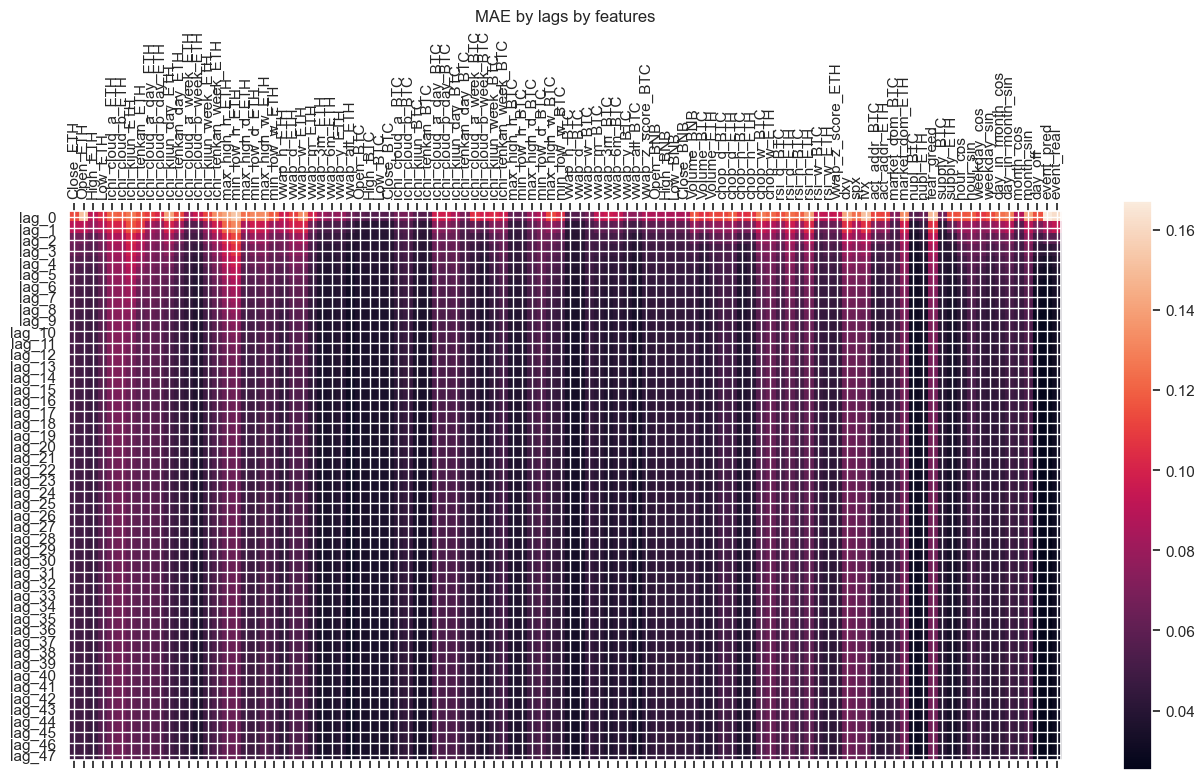

In [87]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

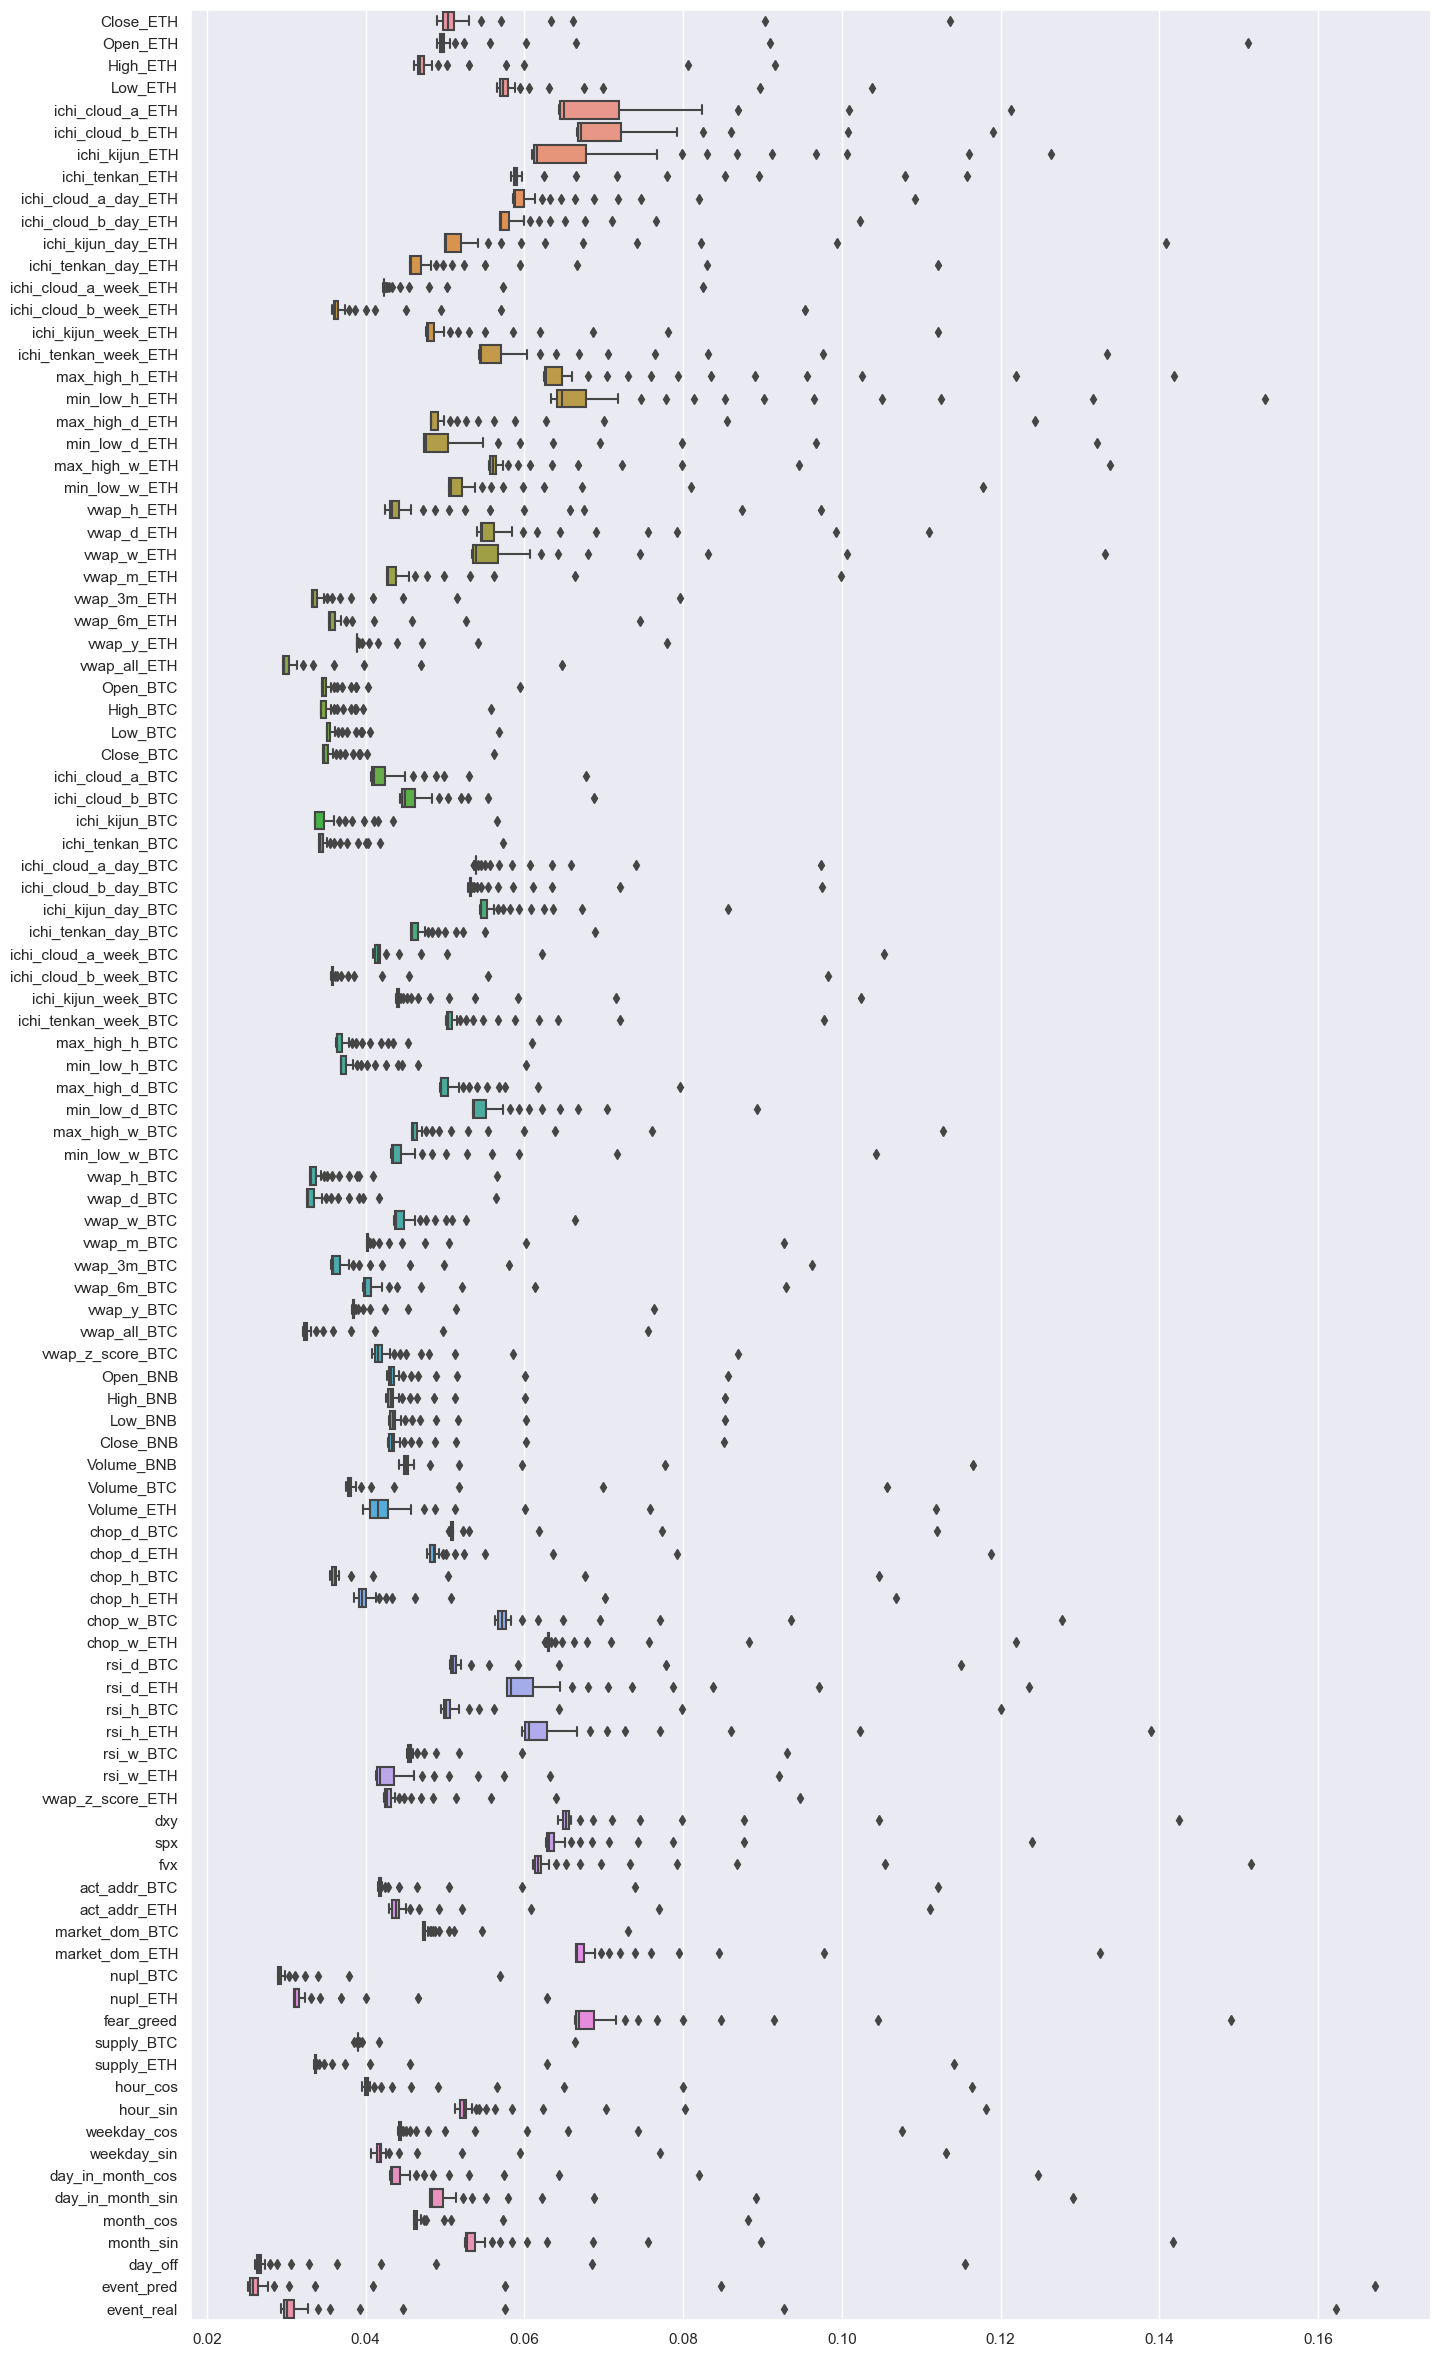

In [88]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [89]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.053274  0.053356  0.049231  0.059676          0.070011   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.071378        0.068846          0.06314              0.061736   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.059569  ...  0.055076     0.047482     0.044596   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0          0.047271          0.052368   0.047561   0.056954  0.03054   

   event_pred  event_real  
0    0.031277    0.035511  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

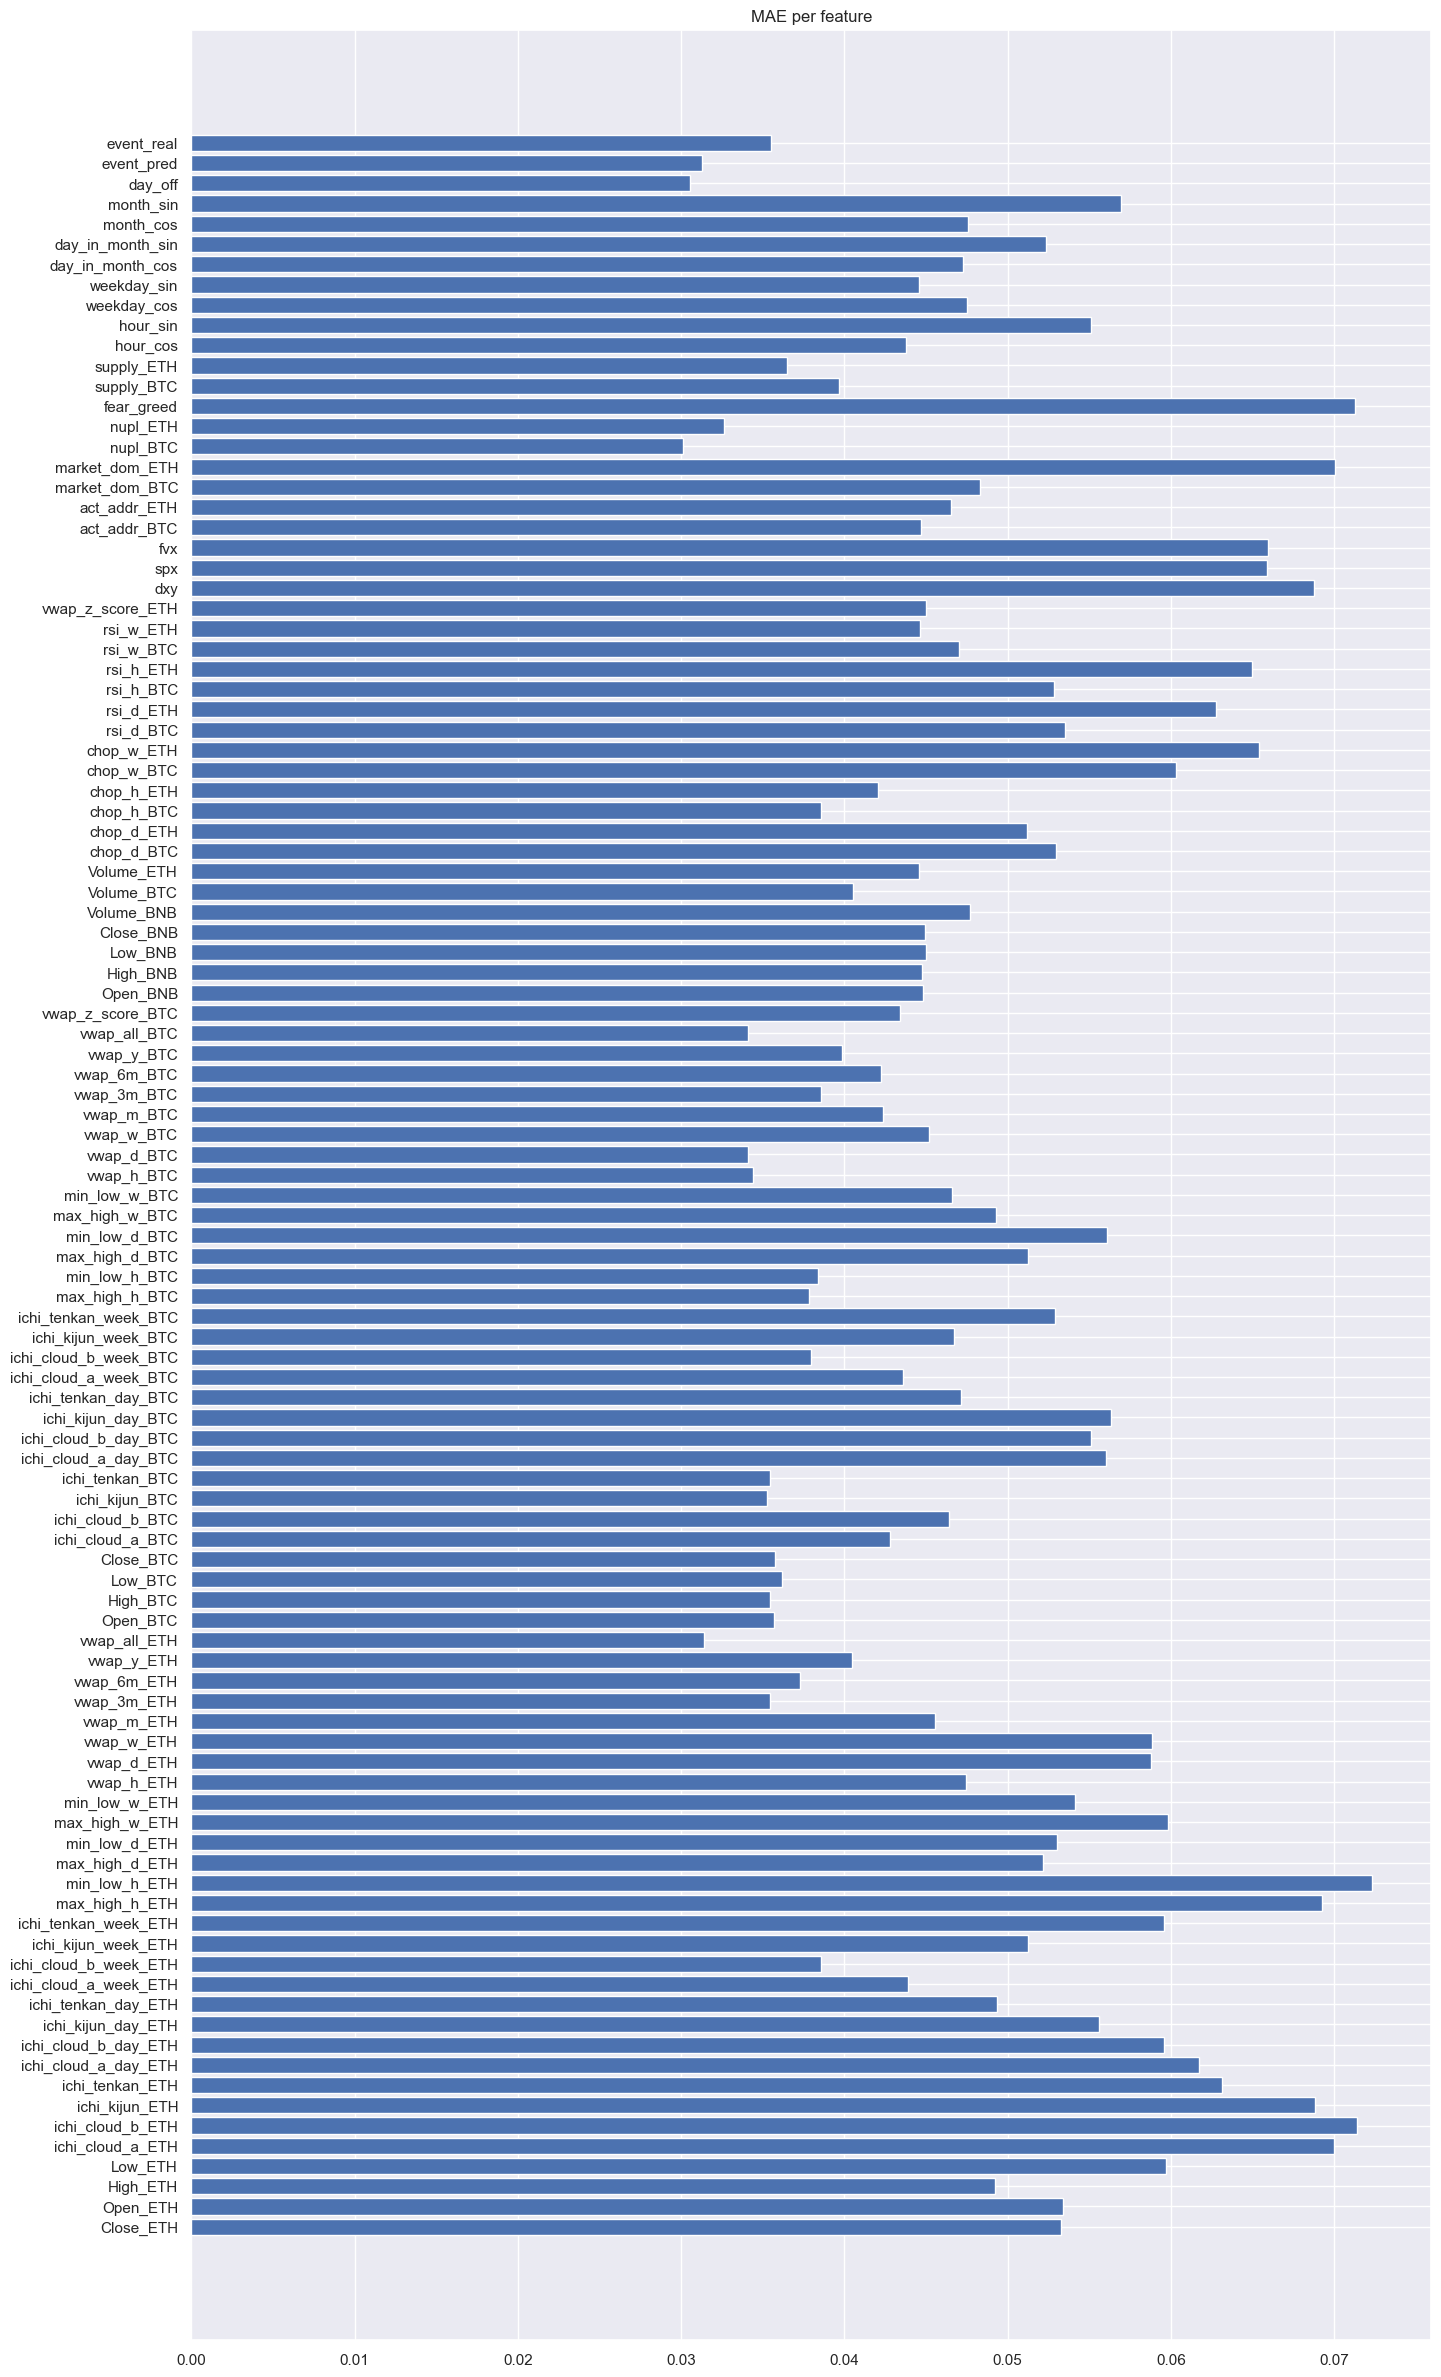

In [90]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [91]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(52635,)
(52635,)
[1196.32 1195.38 1194.55 ... 1905.22 1907.   1908.81]
[1196.32 1195.38 1194.55]


In [92]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.0011691 , 1.001066  , 1.0009996 , ..., 1.00015   , 0.99994236,
       0.9997758 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1905.22 1907.   1908.81]
[1203.05870422 1202.81777388 1201.92735844 ... 1902.55682832 1902.76686891
 1904.17199442]


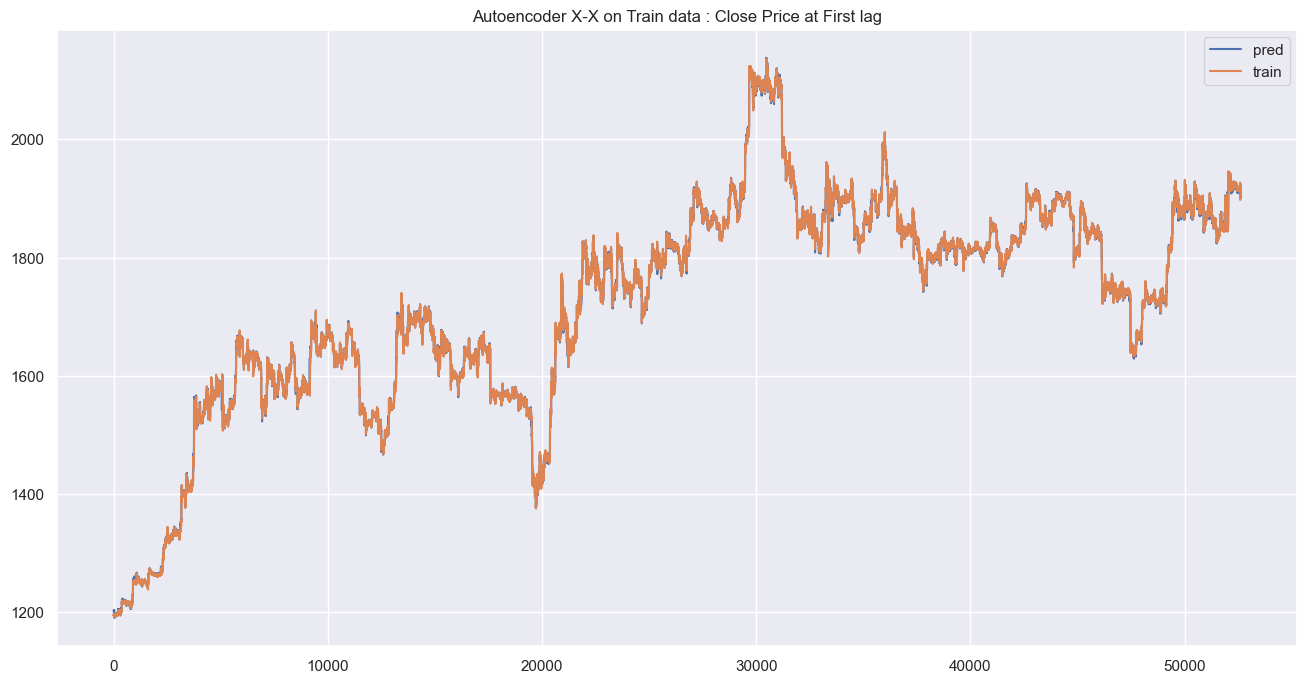

In [93]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [94]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

10/17 [================>.............] - ETA: 0s

17/17 [==============================] - 1s 29ms/step


(517, 48, 104)

In [95]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-02 23:25:00'

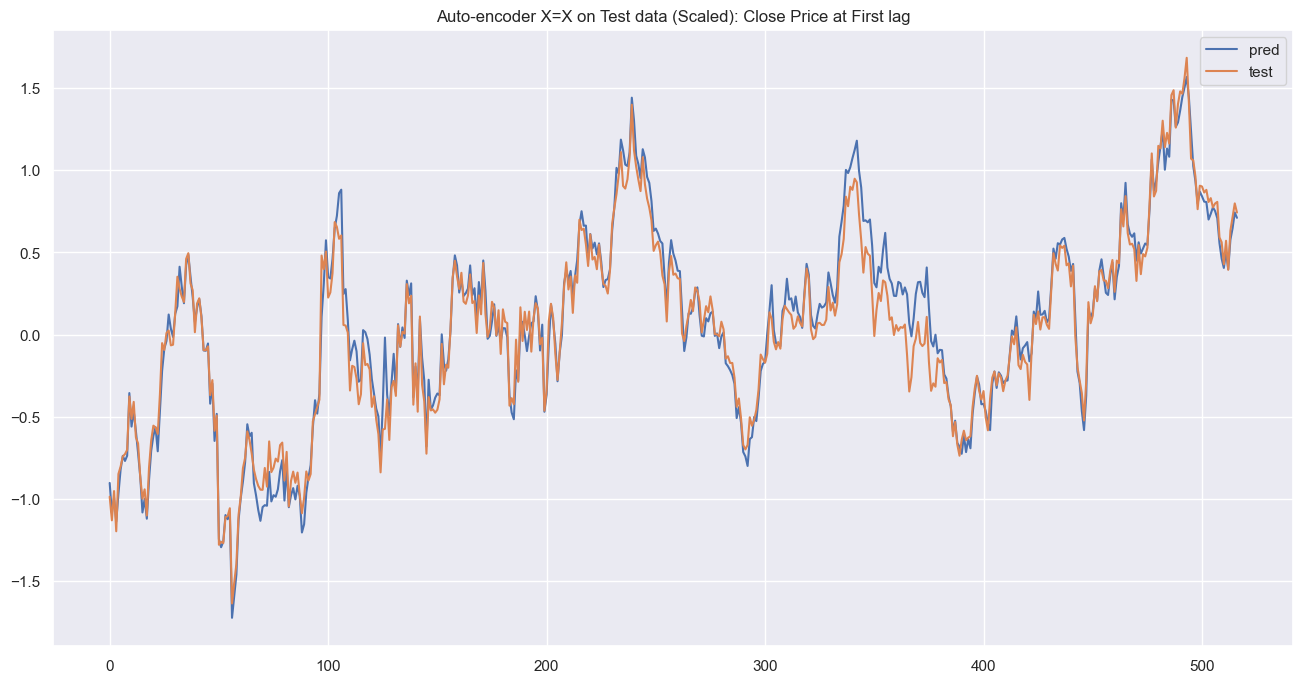

In [96]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [97]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1935.11 1933.28 1934.83 1931.63 1937.02 1937.48 1937.79 1939.14 1940.54]
X test pred :  [1936.3375647  1933.94125813 1934.22632391 1932.49140548 1935.24078202
 1937.21601019 1937.84931108 1938.5271301  1940.01898006]


[1935.11 1933.28 1934.83 1931.63 1937.02 1937.48 1937.79 1939.14 1940.54
 1940.34 1939.28 1939.86 1938.11 1937.25 1935.27 1936.21 1936.44 1934.88
 1936.67 1937.77 1938.31 1938.45 1940.   1941.57 1948.3  1946.29 1947.99
 1947.11 1945.19 1944.99 1947.16 1950.47 1948.88 1947.83 1948.46 1949.94
 1951.26 1949.15 1949.94 1948.14 1948.69 1949.18 1949.   1948.08 1948.42
 1948.75 1949.84 1949.92 1950.2  1949.13 1949.52 1949.8  1949.6  1949.01
 1950.15 1951.18 1946.2  1947.14 1946.2  1947.61 1947.3  1948.34 1951.21
 1950.6  1951.38 1948.9  1947.56 1946.77 1947.07 1949.21 1947.22 1949.41
 1948.01 1948.2  1947.09 1946.5  1946.24 1945.57 1945.67 1945.16 1944.8
 1945.91 1943.56 1944.37 1944.94 1946.34 1948.28 1946.27 1946.3  1947.85
 1949.82 1950.17 1950.15 1955.61 1954.34 1959.17 1956.73 1968.8  1968.81
 1968.73 1965.78 1966.83 1967.16 1970.79 1969.87 1967.19 1964.14 1962.19
 1960.67 1962.62 1959.63 1961.19 1959.9  1960.02 1960.07 1960.99 1963.49
 1961.5  1961.73 1962.01 1958.12 1959.77 1958.78 195

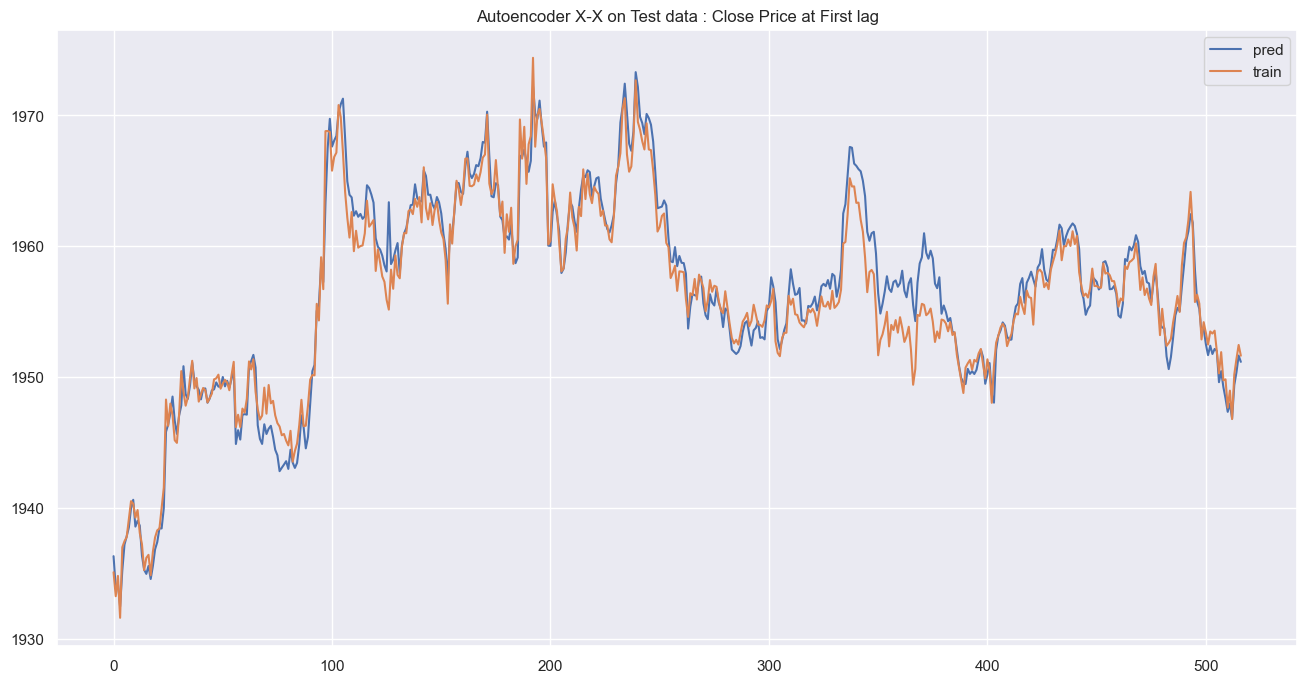

In [98]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [99]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(517, 48, 104)
(517, 48, 104)
(48, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113608  0.151239  0.091531  0.103804          0.121335   
lag_1    0.090326  0.090926  0.080625  0.089680          0.100904   
lag_2    0.066108  0.066565  0.059998  0.069947          0.086885   
lag_3    0.063357  0.060163  0.057700  0.067583          0.082326   
lag_4    0.057120  0.055677  0.053000  0.063086          0.079340   
...           ...       ...       ...       ...               ...   
lag_43   0.045655  0.055797  0.041806  0.058561          0.056509   
lag_44   0.046008  0.055890  0.041863  0.058390          0.056373   
lag_45   0.045523  0.056159  0.041731  0.058602          0.056282   
lag_46   0.045688  0.055995  0.041820  0.058555          0.056265   
lag_47   0.045507  0.056063  0.041907  0.058769          0.056146   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119048        0.126331         0.115768   
lag_1           0.100800        0.116055         0.108019   
lag_2           0.086047        0.100679         0.089520   
lag_3           0.082483        0.096797         0.085295   
lag_4           0.079288        0.091228         0.078016   
...                  ...             ...              ...   
lag_43          0.054106        0.054607         0.053920   
lag_44          0.054149        0.054275         0.053473   
lag_45          0.054311        0.054172         0.053120   
lag_46          0.054467        0.053651         0.052989   
lag_47          0.054755        0.053605         0.053001   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109164              0.102233  ...     0.107601   
lag_1               0.082005              0.076555  ...     0.074301   
lag_2               0.074688              0.071028  ...     0.065492   
lag_3               0.071746              0.067624  ...     0.060320   
lag_4               0.068808              0.065183  ...     0.053838   
...                      ...                   ...  ...          ...   
lag_43              0.128102              0.125638  ...     0.125273   
lag_44              0.128122              0.125824  ...     0.125290   
lag_45              0.128205              0.126003  ...     0.125231   
lag_46              0.128230              0.126156  ...     0.125223   
lag_47              0.128339              0.126249  ...     0.125115   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113122          0.124776          0.129188   0.088171   0.141718   
lag_1      0.077063          0.081949          0.089200   0.057288   0.089844   
lag_2      0.059462          0.064413          0.068816   0.050776   0.075535   
lag_3      0.052114          0.057477          0.062269   0.049883   0.068627   
lag_4      0.046495          0.052992          0.057987   0.047592   0.062827   
...             ...               ...               ...        ...        ...   
lag_43     0.120165          0.166839          0.170033   0.099547   0.406550   
lag_44     0.120178          0.167240          0.169444   0.099654   0.406836   
lag_45     0.120144          0.167521          0.168913   0.099699   0.407227   
lag_46     0.119900          0.167908          0.168289   0.099796   0.407564   
lag_47     0.119732          0.168150          0.167761   0.099840   0.407977   

         day_off  event_pred  event_real  dataset  
lag_0   0.115550    0.167176    0.162222    TRAIN  
lag_1   0.068515    0.084829    0.092697    TRAIN  
lag_2   0.048907    0.057581    0.057592    TRAIN  
lag_3   0.041973    0.040884    0.044666    TRAIN  
lag_4   0.036415    0.033658    0.039291    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.251981    0.063802    0.108080     TEST  
lag_44  0.252122    0.063740    0.107904     TEST  
lag_45  0.252217    0.063584    0.107736     TEST  
lag_46  0.252323    0.063560    0.107503     TEST  
lag_47  0.252386    0.063533    0.10

In [100]:
df_mae_ae_comp

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113608  0.151239  0.091531  0.103804          0.121335   
lag_1    0.090326  0.090926  0.080625  0.089680          0.100904   
lag_2    0.066108  0.066565  0.059998  0.069947          0.086885   
lag_3    0.063357  0.060163  0.057700  0.067583          0.082326   
lag_4    0.057120  0.055677  0.053000  0.063086          0.079340   
...           ...       ...       ...       ...               ...   
lag_43   0.045655  0.055797  0.041806  0.058561          0.056509   
lag_44   0.046008  0.055890  0.041863  0.058390          0.056373   
lag_45   0.045523  0.056159  0.041731  0.058602          0.056282   
lag_46   0.045688  0.055995  0.041820  0.058555          0.056265   
lag_47   0.045507  0.056063  0.041907  0.058769          0.056146   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119048        0.126331         0.115768   
lag_1           0.100800        0.116055         0.108019   
lag_2           0.086047        0.100679         0.089520   
lag_3           0.082483        0.096797         0.085295   
lag_4           0.079288        0.091228         0.078016   
...                  ...             ...              ...   
lag_43          0.054106        0.054607         0.053920   
lag_44          0.054149        0.054275         0.053473   
lag_45          0.054311        0.054172         0.053120   
lag_46          0.054467        0.053651         0.052989   
lag_47          0.054755        0.053605         0.053001   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109164              0.102233  ...     0.107601   
lag_1               0.082005              0.076555  ...     0.074301   
lag_2               0.074688              0.071028  ...     0.065492   
lag_3               0.071746              0.067624  ...     0.060320   
lag_4               0.068808              0.065183  ...     0.053838   
...                      ...                   ...  ...          ...   
lag_43              0.128102              0.125638  ...     0.125273   
lag_44              0.128122              0.125824  ...     0.125290   
lag_45              0.128205              0.126003  ...     0.125231   
lag_46              0.128230              0.126156  ...     0.125223   
lag_47              0.128339              0.126249  ...     0.125115   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113122          0.124776          0.129188   0.088171   0.141718   
lag_1      0.077063          0.081949          0.089200   0.057288   0.089844   
lag_2      0.059462          0.064413          0.068816   0.050776   0.075535   
lag_3      0.052114          0.057477          0.062269   0.049883   0.068627   
lag_4      0.046495          0.052992          0.057987   0.047592   0.062827   
...             ...               ...               ...        ...        ...   
lag_43     0.120165          0.166839          0.170033   0.099547   0.406550   
lag_44     0.120178          0.167240          0.169444   0.099654   0.406836   
lag_45     0.120144          0.167521          0.168913   0.099699   0.407227   
lag_46     0.119900          0.167908          0.168289   0.099796   0.407564   
lag_47     0.119732          0.168150          0.167761   0.099840   0.407977   

         day_off  event_pred  event_real  dataset  
lag_0   0.115550    0.167176    0.162222    TRAIN  
lag_1   0.068515    0.084829    0.092697    TRAIN  
lag_2   0.048907    0.057581    0.057592    TRAIN  
lag_3   0.041973    0.040884    0.044666    TRAIN  
lag_4   0.036415    0.033658    0.039291    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.251981    0.063802    0.108080     TEST  
lag_44  0.252122    0.063740    0.107904     TEST  
lag_45  0.252217    0.063584    0.107736     TEST  
lag_46  0.252323    0.063560    0.107503     TEST  
lag_47  0.252386    0.063533    0.10

In [101]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0      TRAIN   Close_ETH  0.113608
1      TRAIN   Close_ETH  0.090326
2      TRAIN   Close_ETH  0.066108
3      TRAIN   Close_ETH  0.063357
4      TRAIN   Close_ETH  0.057120
...      ...         ...       ...
9979    TEST  event_real  0.108080
9980    TEST  event_real  0.107904
9981    TEST  event_real  0.107736
9982    TEST  event_real  0.107503
9983    TEST  event_real  0.107425

[9984 rows x 3 columns]

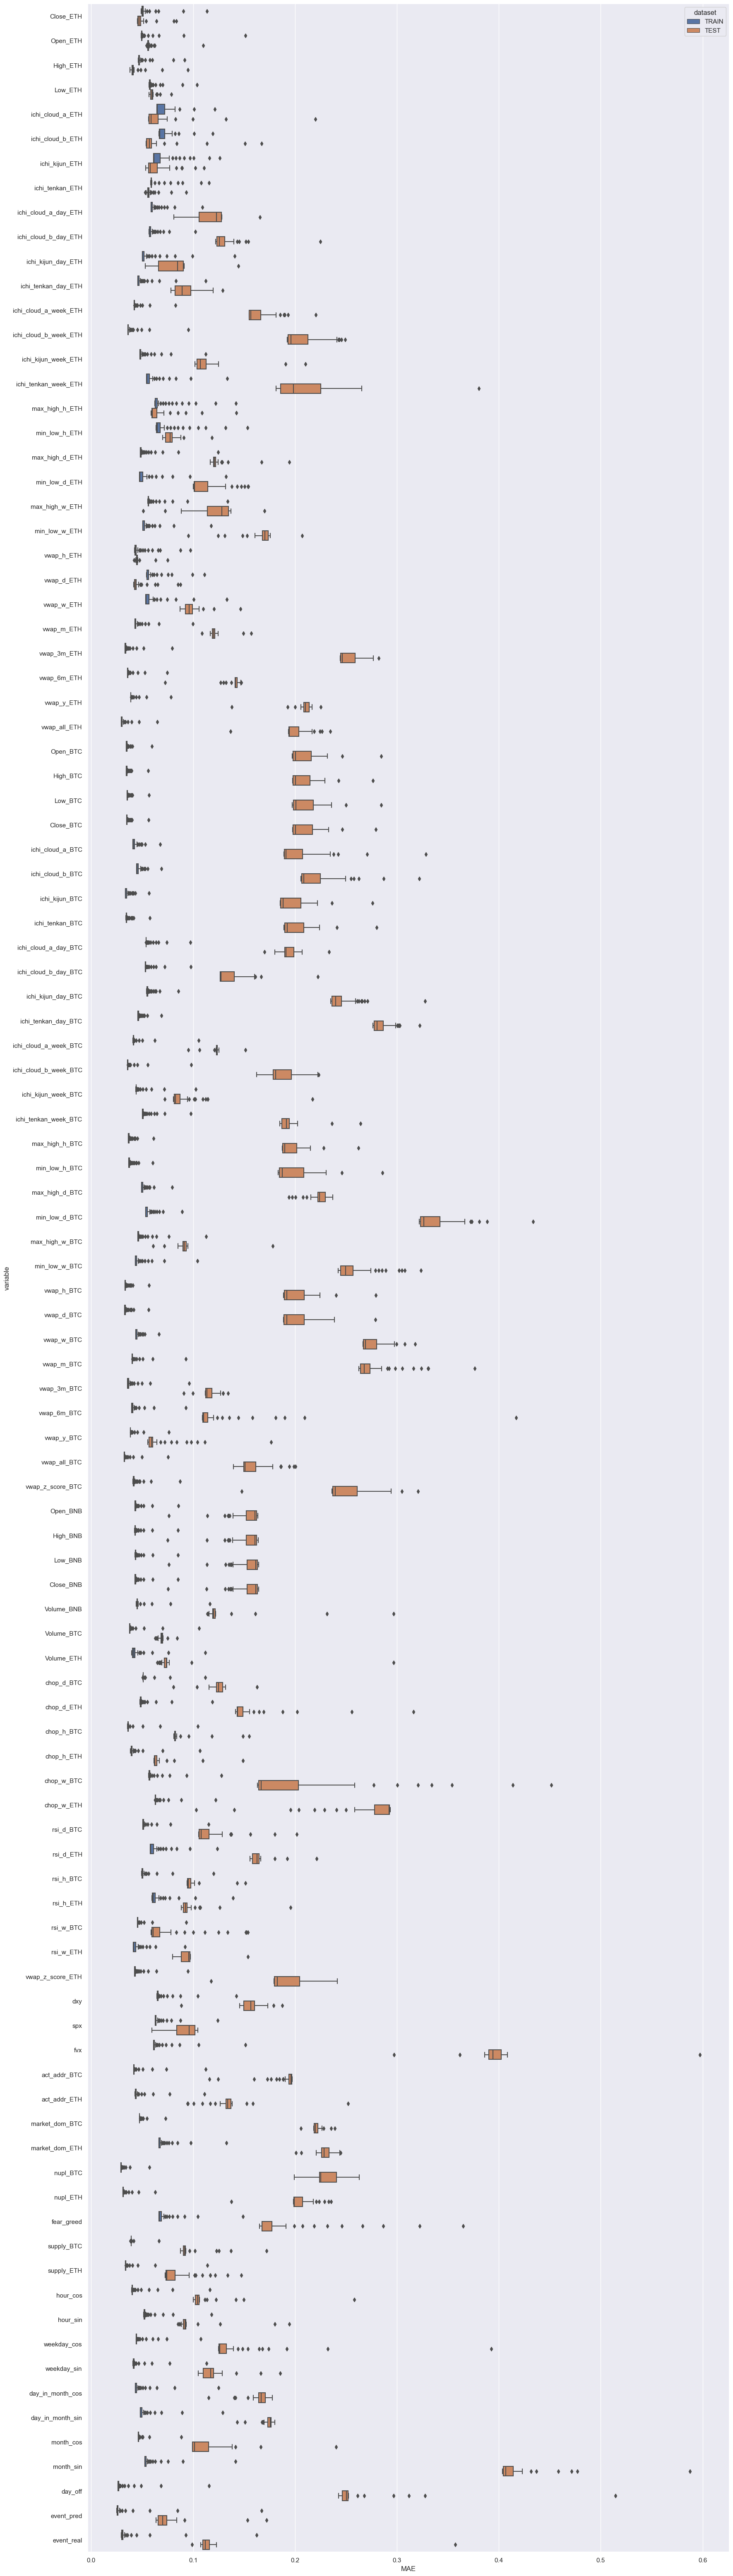

In [102]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

In [103]:
encoder_model.layers[3].get_weights()

[array([[ 0.842958  ,  0.5063907 ,  0.45411888, ...,  0.01483321,
          1.5882727 , -0.36009565],
        [-0.11249828,  0.11688974,  0.3335934 , ...,  0.04197494,
          0.25292554, -0.02393412],
        [ 0.04484627,  0.10462276,  0.05259531, ...,  0.12596804,
          0.16488573,  0.18017781],
        ...,
        [ 0.20715614,  0.02664023, -0.27958483, ...,  0.03626311,
         -0.06333295, -0.3152785 ],
        [ 0.02469139, -0.06407242,  0.2248977 , ..., -0.17936683,
         -0.03836902, -0.2845099 ],
        [-0.3445294 , -0.33057272, -0.27452046, ...,  0.15807603,
          0.34676582,  0.1296677 ]], dtype=float32),
 array([-4.6747448e-03,  2.6166180e-01, -1.1138902e-01,  1.3655911e-01,
        -3.0430162e-02,  2.7835512e-01, -1.2995267e-01,  1.8006296e-01,
         3.4296926e-02,  1.7117482e-01,  6.6168085e-02, -2.8049654e-01,
         3.2343674e-02, -4.1865915e-02,  3.6488373e-02,  3.2718420e-02,
        -2.9019001e-01,  1.9895509e-04,  9.0200752e-02,  1.2685241e-01

## Prediction Models

### LSTM all features

In [104]:
X_train_sca.shape

(52635, 48, 104)

In [105]:
X_train_sca.shape[-1]

104

In [106]:
X_train_sca.shape[-2:]

(48, 104)

In [107]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [108]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [109]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1645/1645 [==============================] - 16s 10ms/step


(52635, 48, 32)

In [110]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 6/17 [=========>....................] - ETA: 0s

17/17 [==============================] - 0s 13ms/step


(517, 48, 32)

In [111]:
if MODE_TRAIN_PREDICTOR:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



In [112]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [113]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [114]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((52635, 48, 36), (517, 48, 36))

#### Correlations

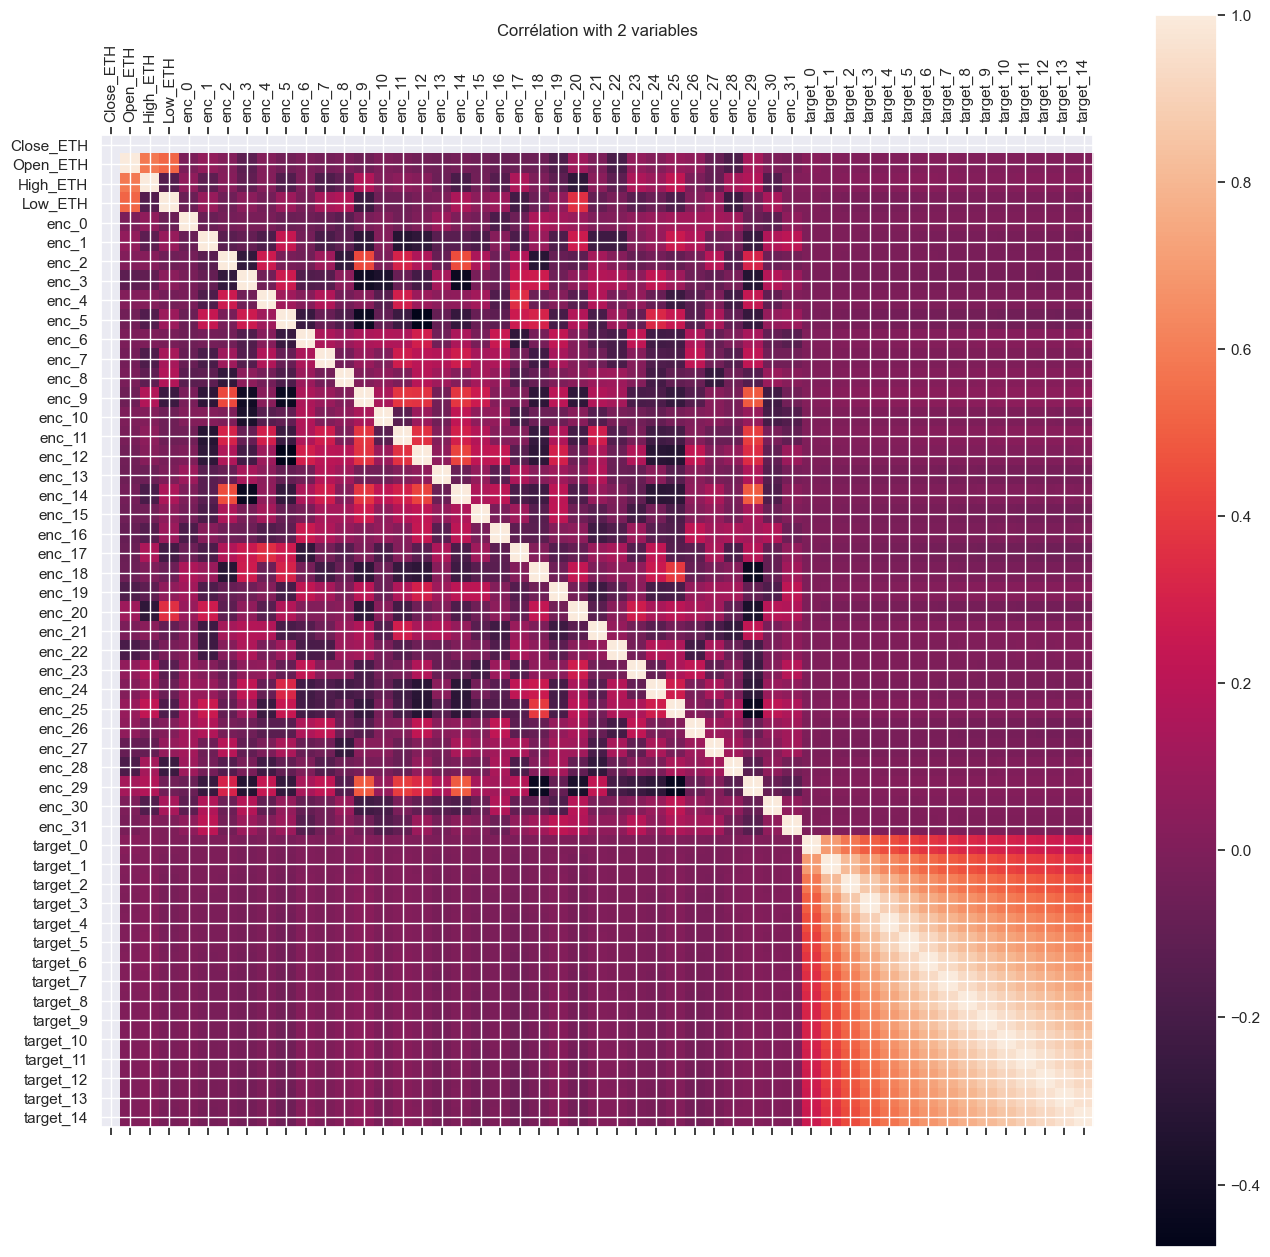

In [115]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)

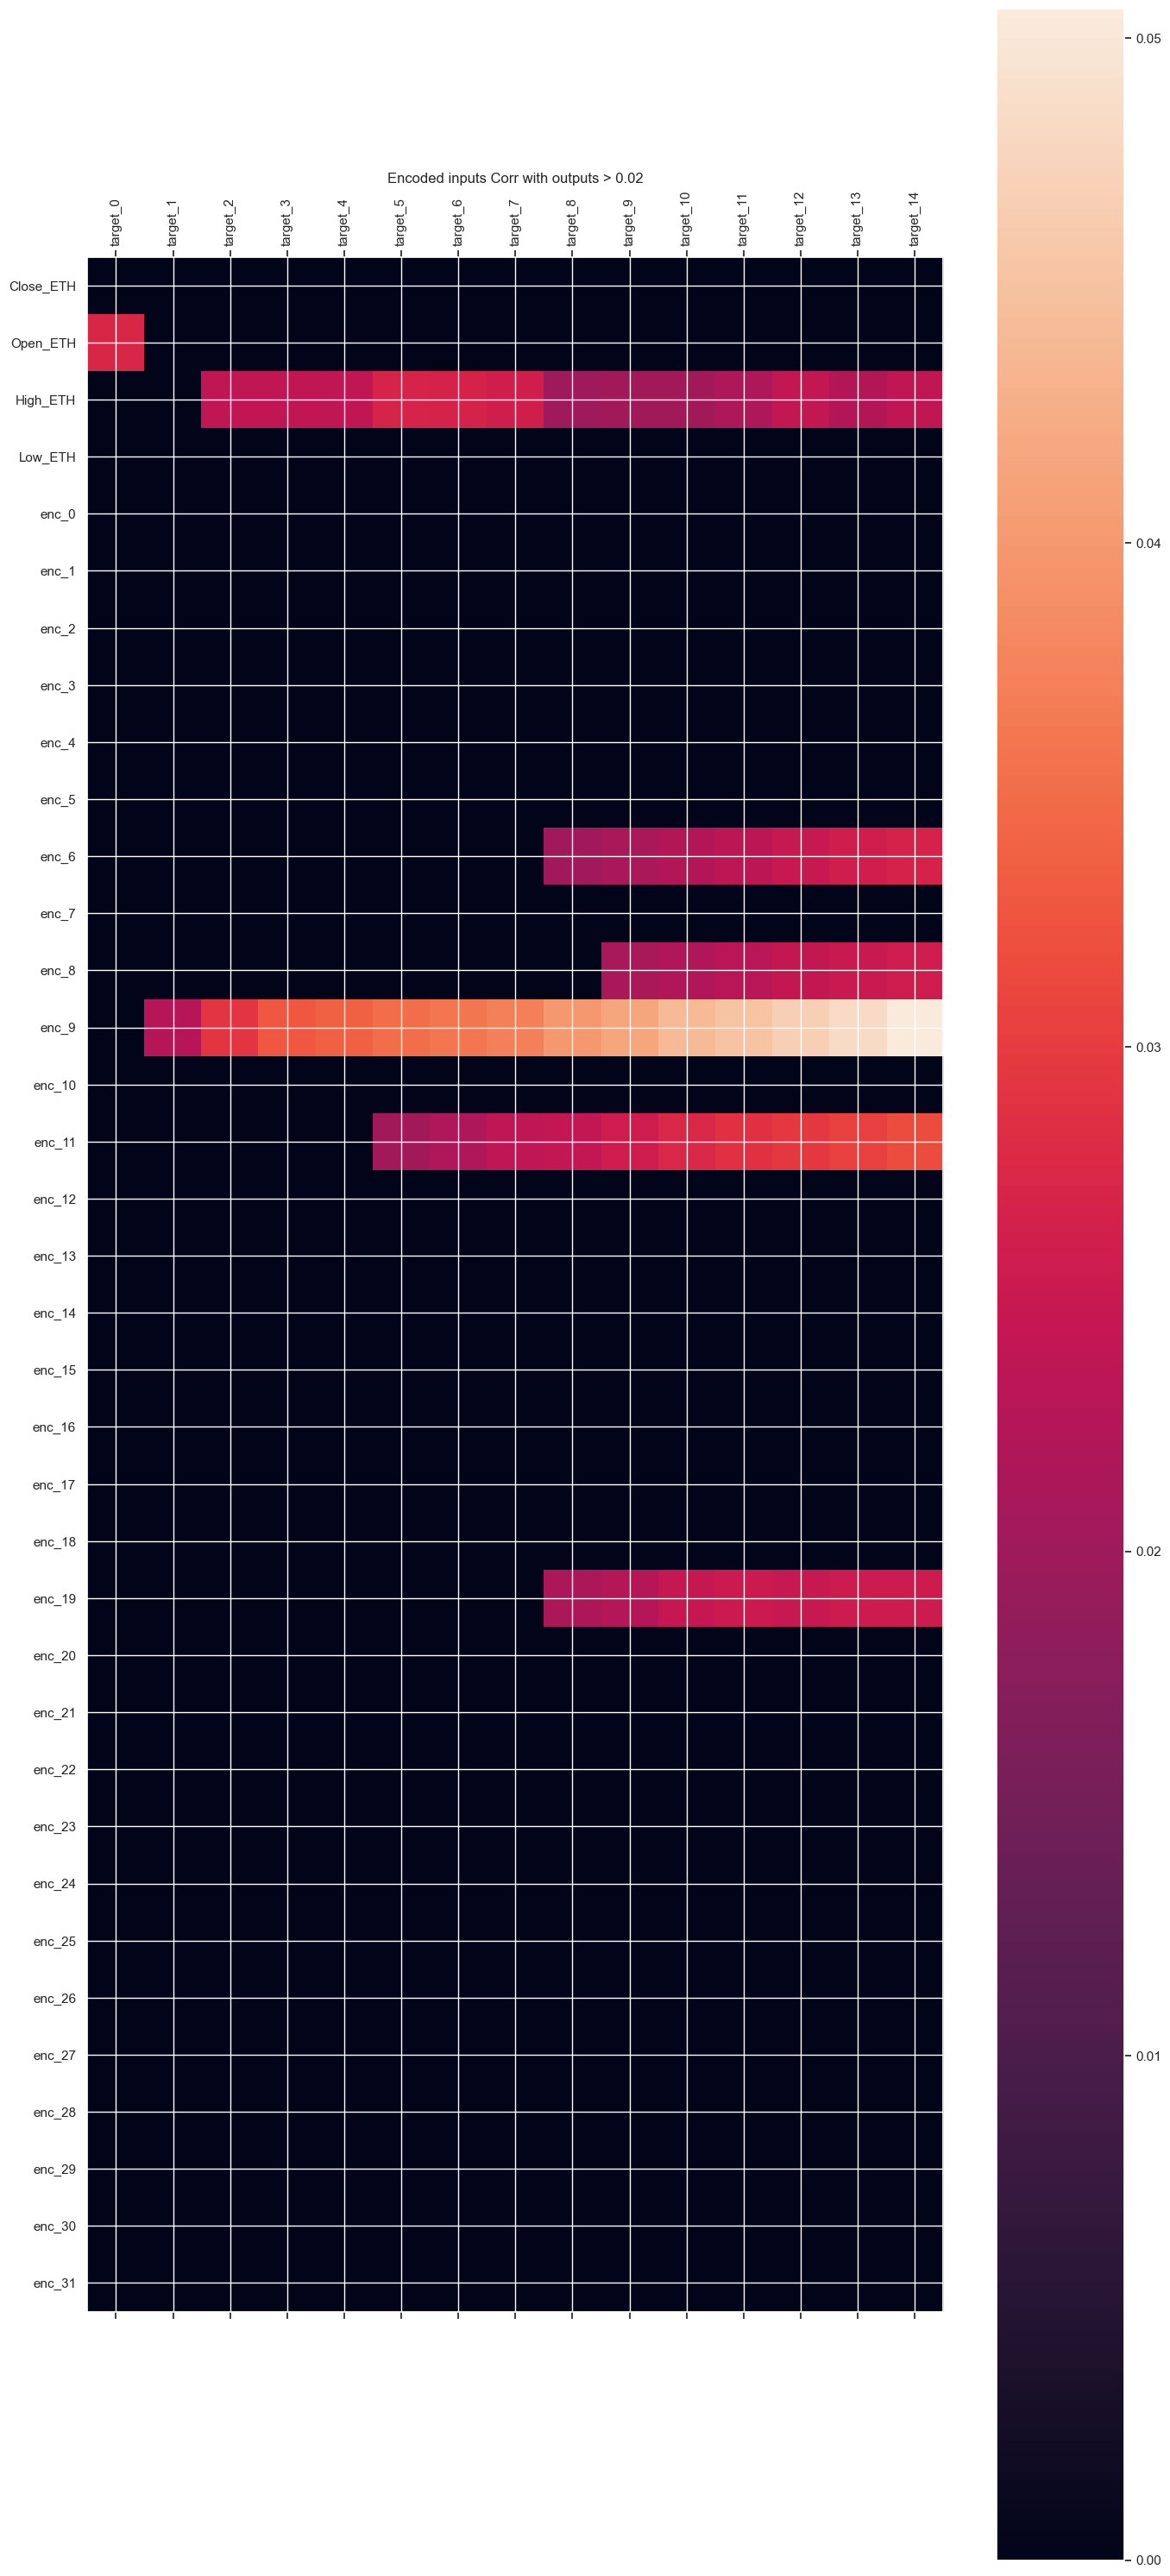

In [116]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")


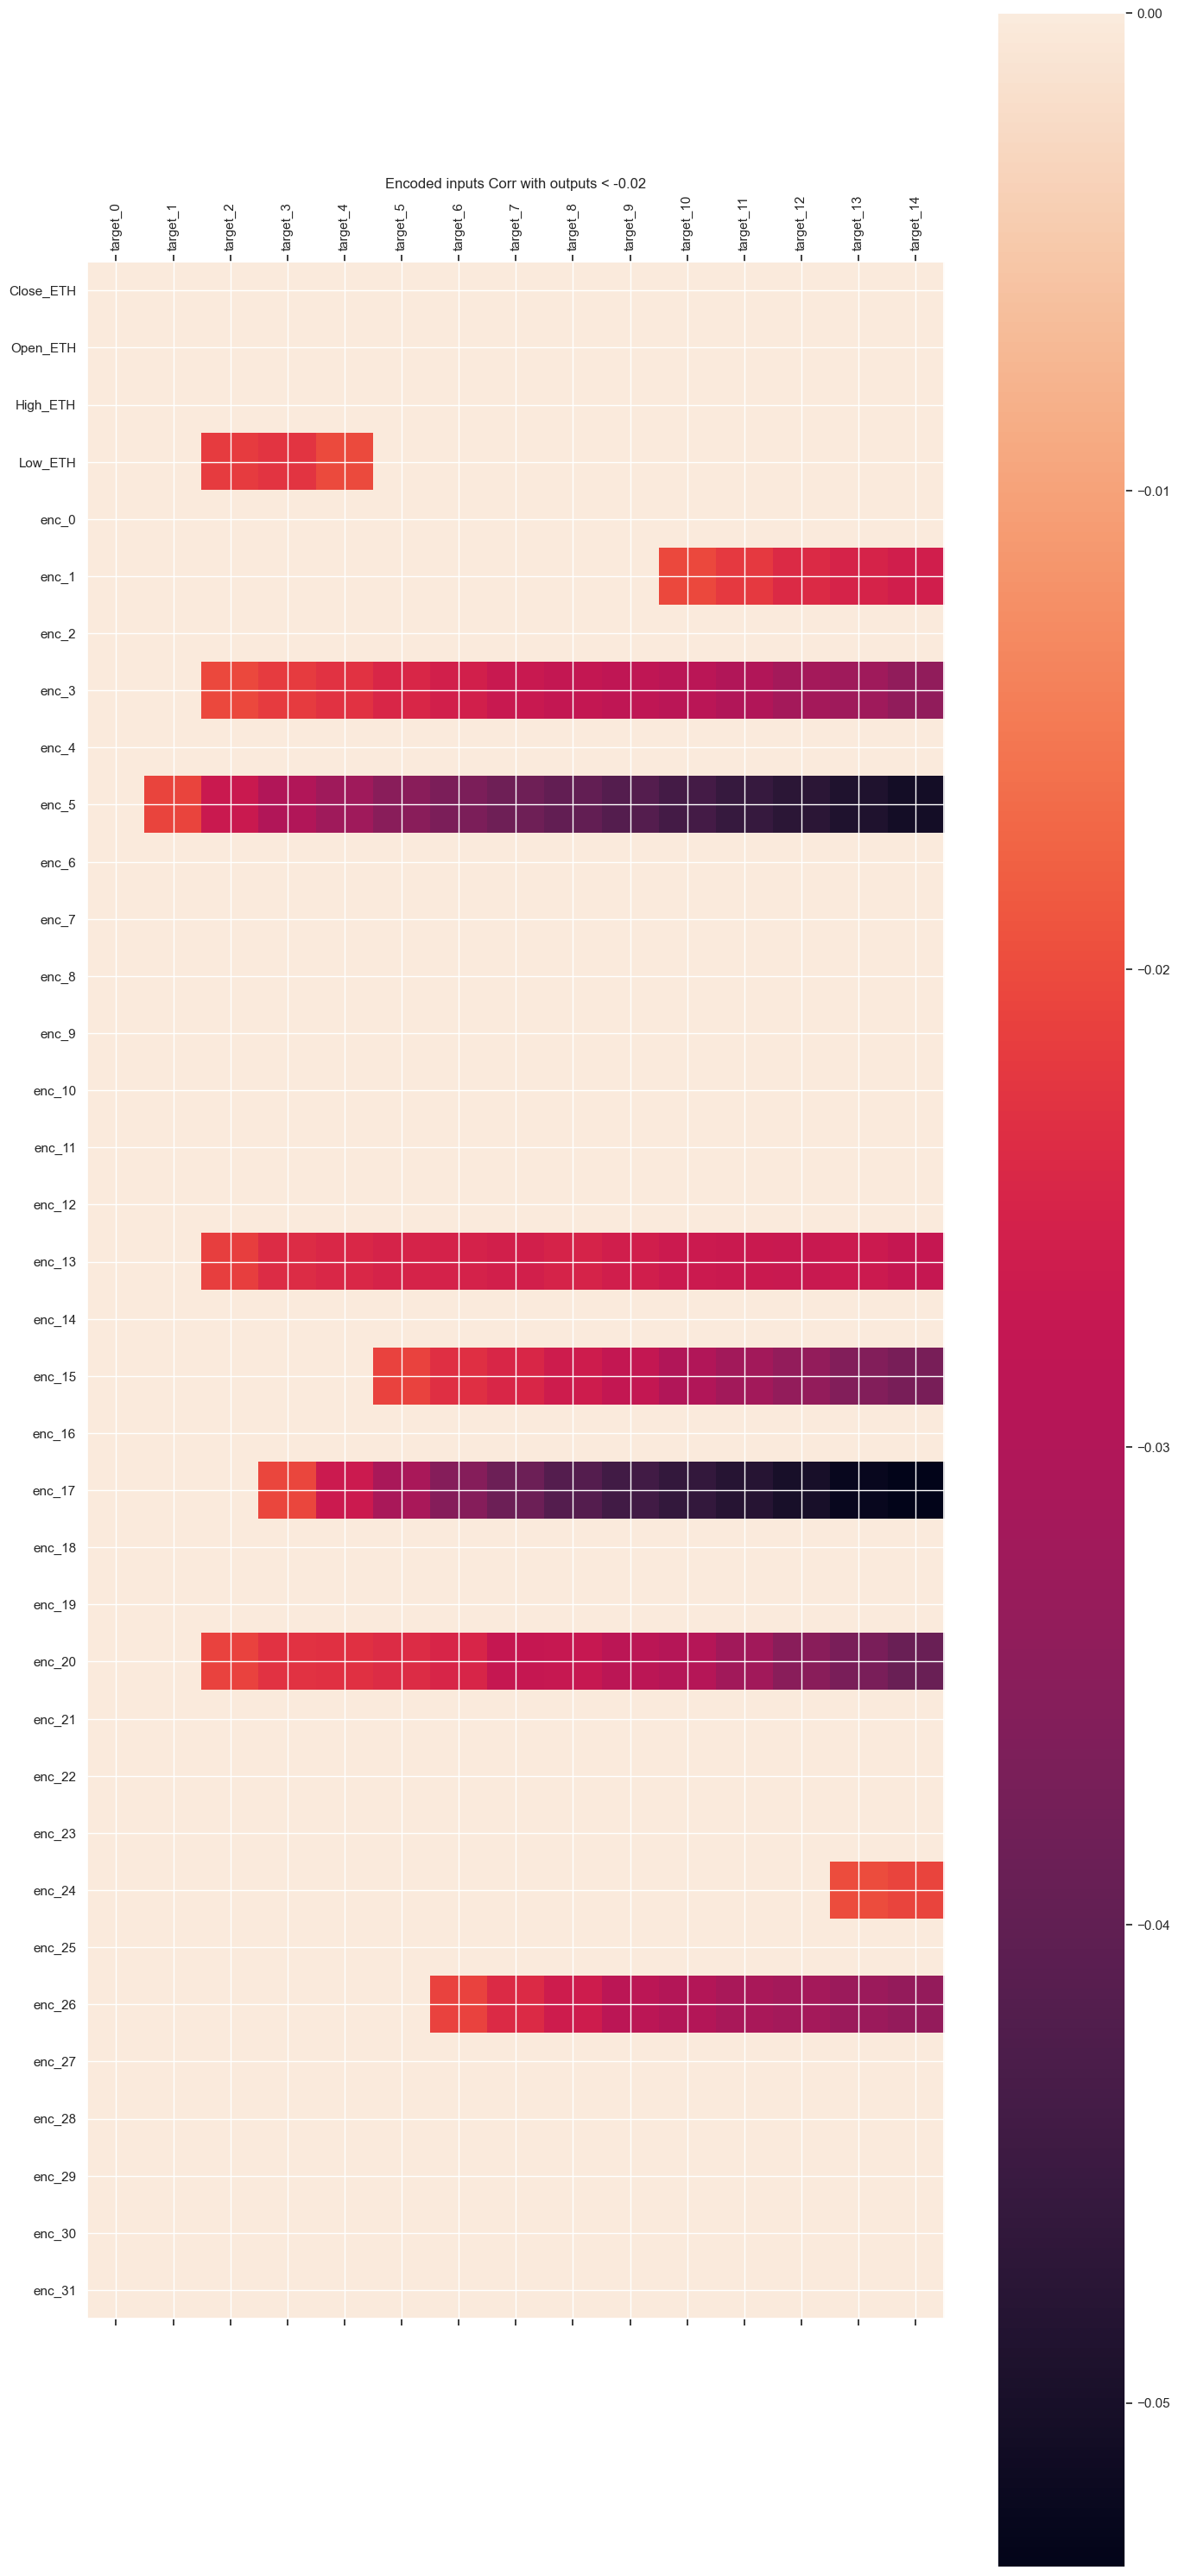

In [117]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)

#### Auto select features 

In [118]:
MODE_AUTO_SELECT

2

In [119]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]
nb encoded features:  15


In [120]:
X_train_.shape

(52635, 48, 36)

In [121]:
np.array(list(range(4)) + list_i_enc_select)

array([ 0,  1,  2,  3,  1,  3,  5,  6,  8,  9, 11, 13, 15, 17, 19, 20, 24,
       26, 27])

In [122]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  5,  7,  9, 10, 12, 13, 15, 17, 19, 21, 23, 24, 28,
       30, 31])

In [123]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [124]:
X_train_.shape

(52635, 48, 19)

#### Train

In [125]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 30
patience = 10
dropout_rate = 0.1
n_units = 32
seed = 0

if MODE_TRAIN_PREDICTOR:

    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
    #                      nesterov=nesterov)
    optim = tf.optimizers.Adam()
    if patience is not None:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                        verbose=1, patience=patience,
                                        restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(
        n_units,
        return_sequences=False,
        input_shape=X_train_.shape[-2:],
        )
    )
    multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
    #multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.LayerNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1,
        )
    else:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1, 
            callbacks=[es],
        )
    # eval
    mse_curr = np.min(multi_step_history.history['val_loss'])
    print("MSE TEST : ", mse_curr)

    # plot MSE
    name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
    plot_train_history(
        multi_step_history,
        f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt}",
        saveFolder="data",
    )


if MODE_TRAIN_PREDICTOR:
    print("Save model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model.save(path_mdl_predict_autoenc_lstm)
else:
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6656      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 layer_normalization (LayerN  (None, 32)               64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
Total params: 7,215
Trainable params: 7,215
Non-trainable params: 0
_________________________________________________________________
None


#### Results

Save mdl

In [126]:
X_train_.shape

(52635, 48, 19)

Predict

In [127]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

  49/1645 [..............................] - ETA: 14s

17/17 [==============================] - 0s 13ms/step


Plots

In [128]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(52635,)
(52635,)


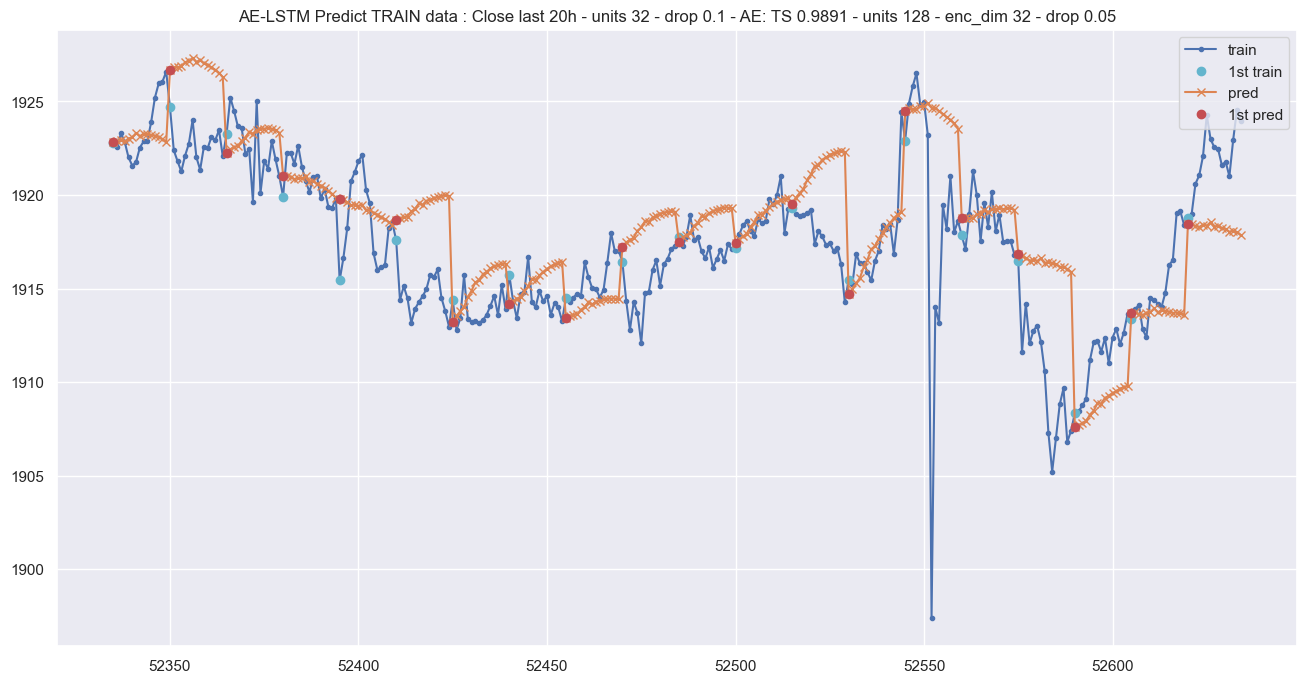

In [129]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

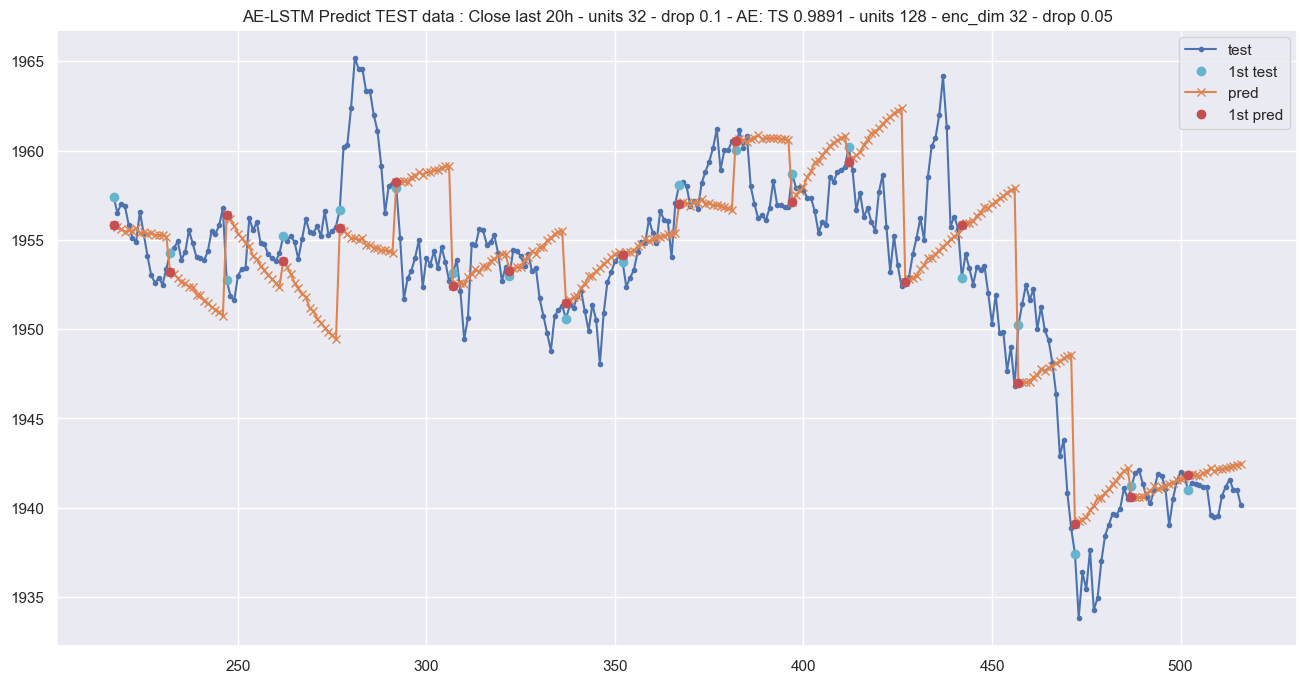

In [130]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

In [131]:
y_test_raw.shape

(517, 15)

In [132]:
y_test_pred_raw.shape

(517, 15)

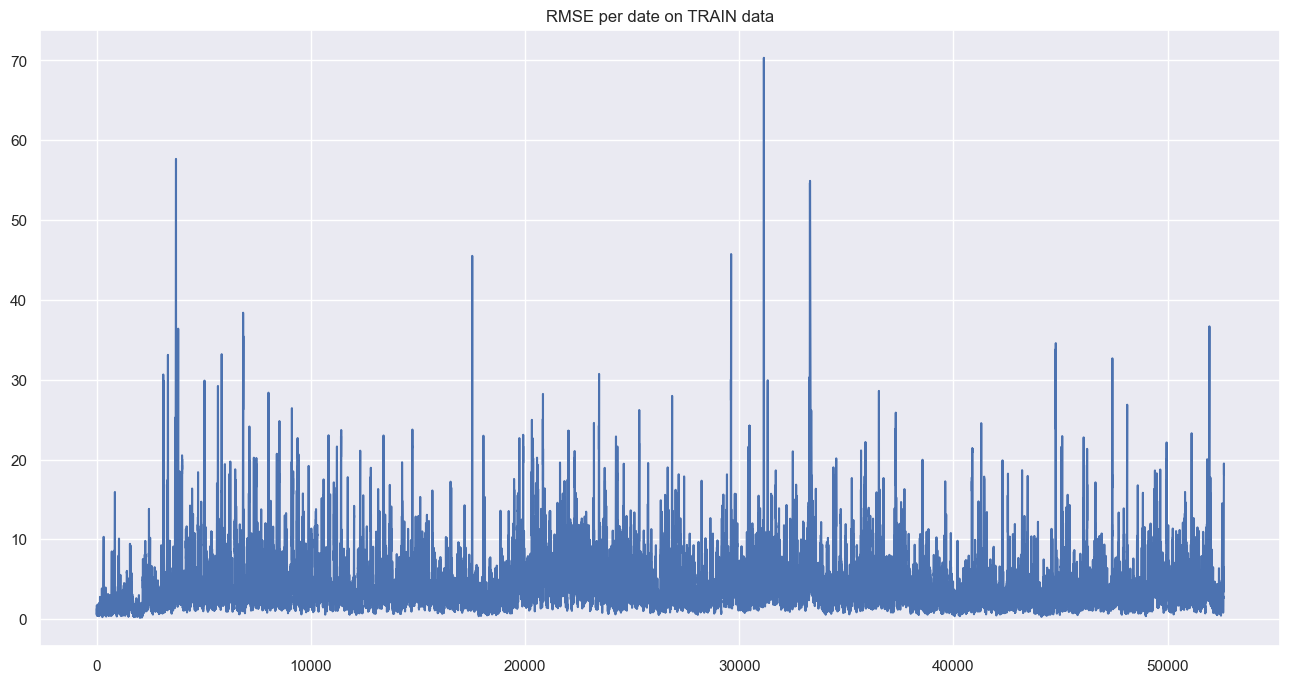

In [133]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

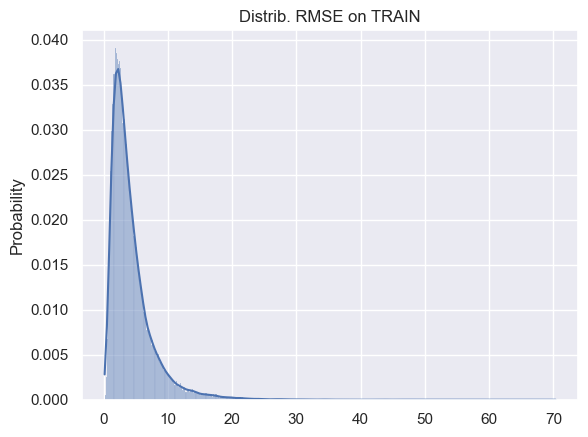

In [134]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.34')

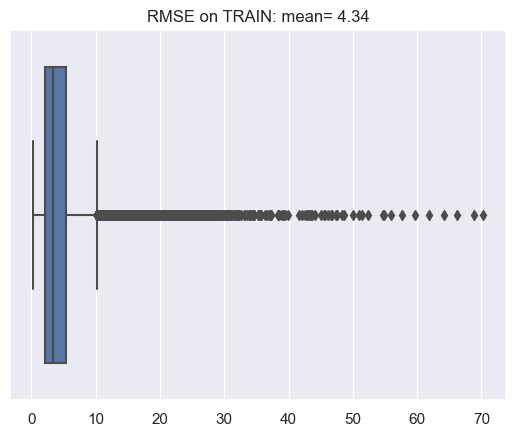

In [135]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

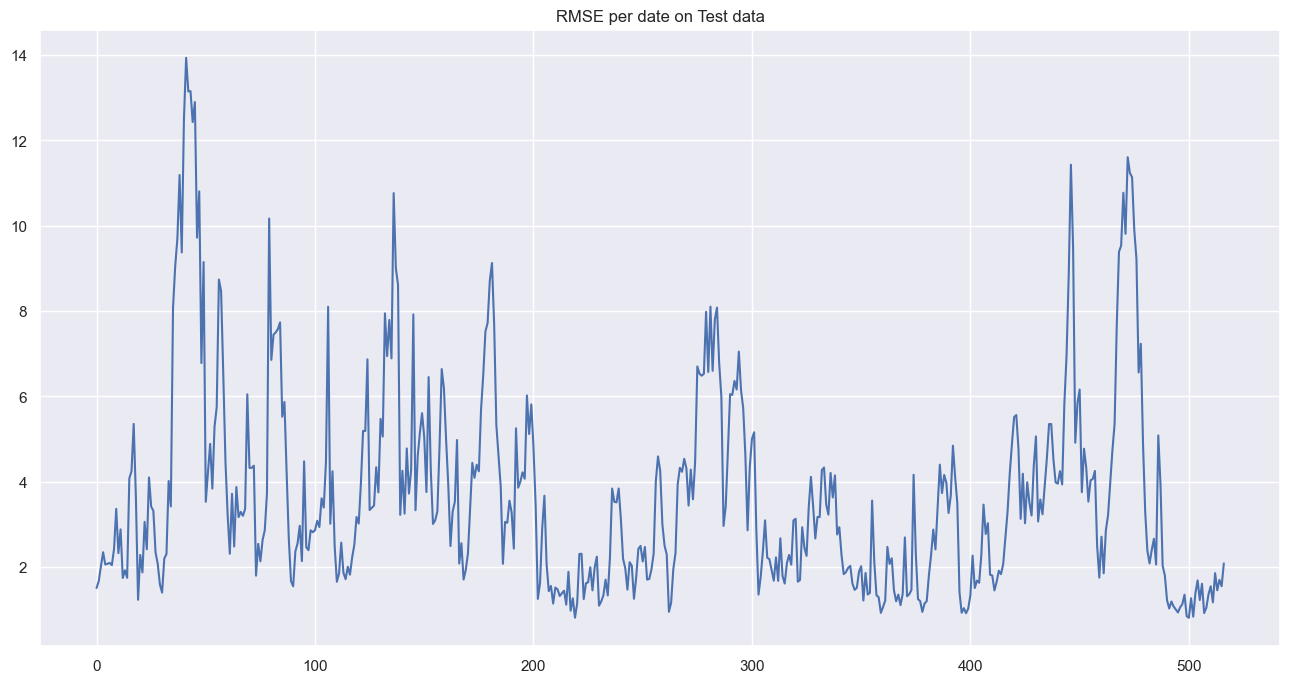

In [136]:
arr_mse = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="mse")

<AxesSubplot: ylabel='Probability'>

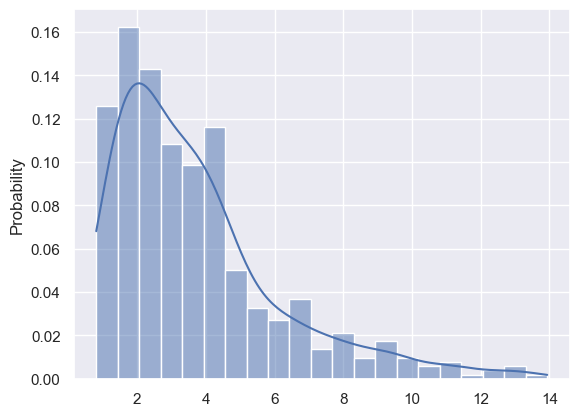

In [137]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.71')

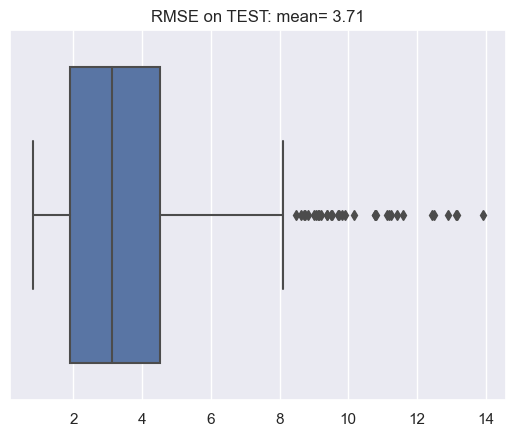

In [138]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [139]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1941.17 1941.16 1939.59 1939.48 1939.54 1940.66 1941.18 1941.57 1941.01
 1941.   1940.14 1938.   1938.11 1938.67 1939.88]
[1941.31360482 1941.30180241 1941.20611032 1941.13170886 1941.28074321
 1941.29439698 1941.49226091 1941.26708944 1941.34692927 1941.32633291
 1941.37238545 1941.3612773  1941.43348028 1941.45986213 1941.47027603]


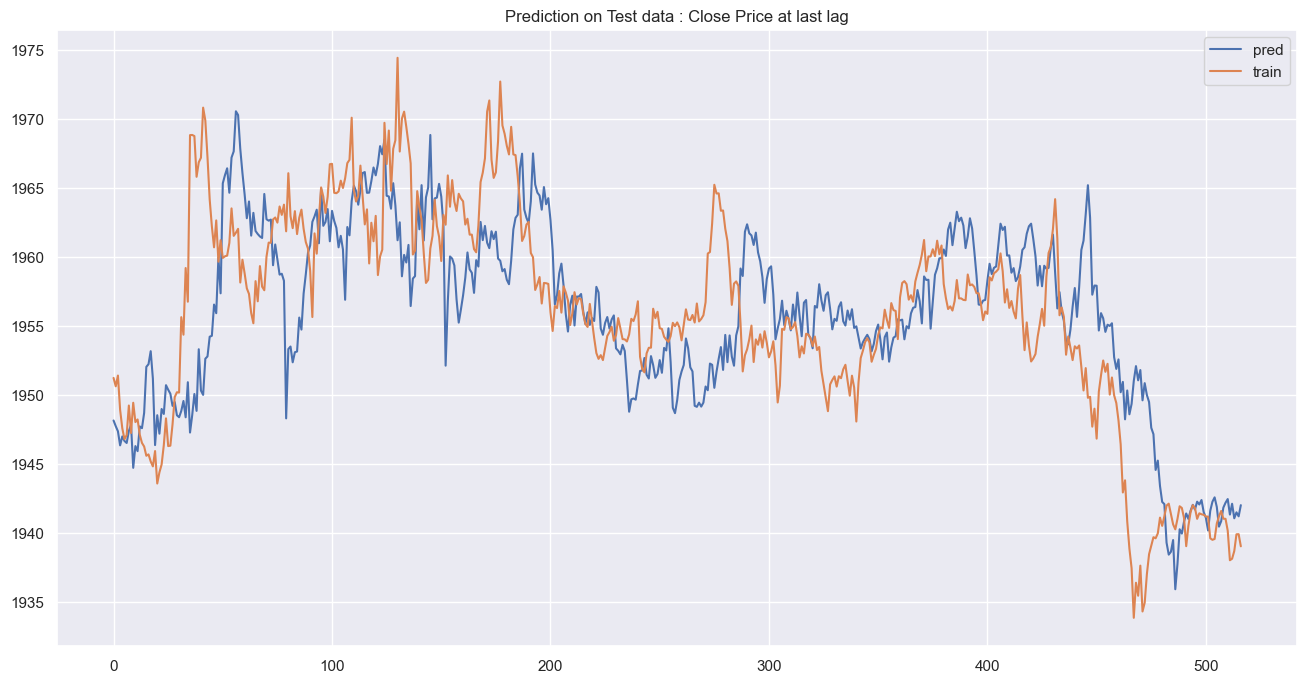

In [140]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

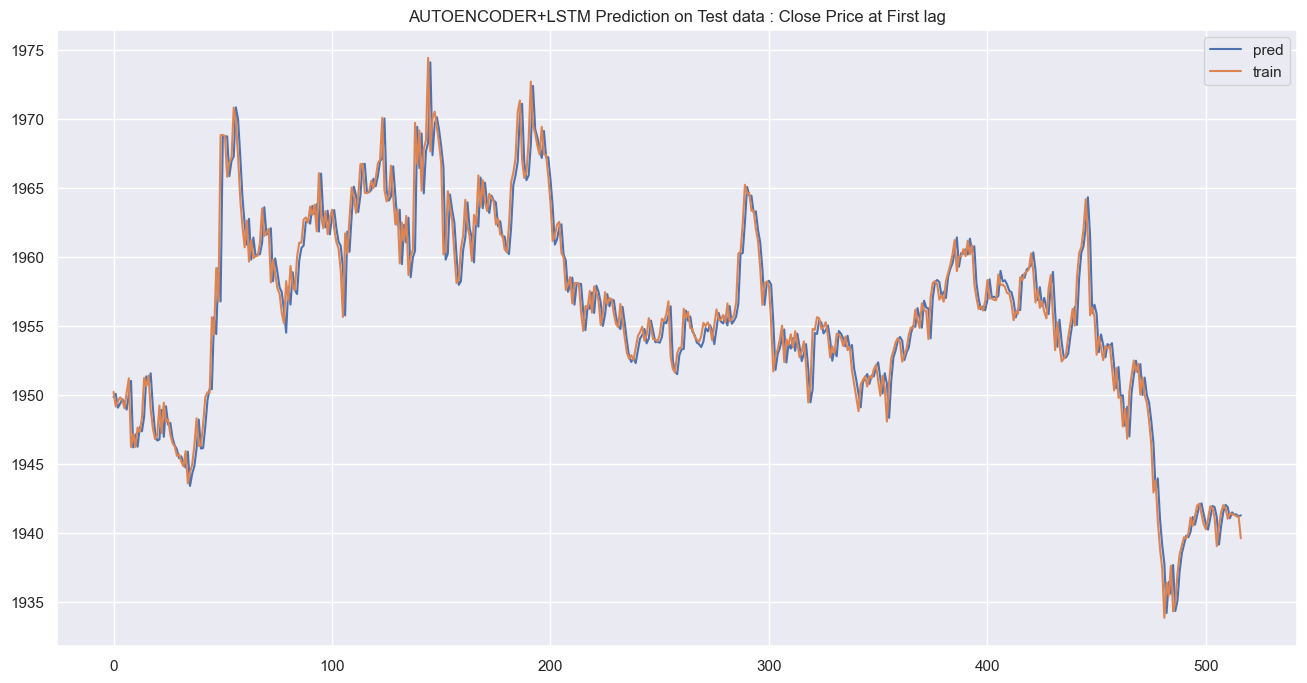

In [141]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

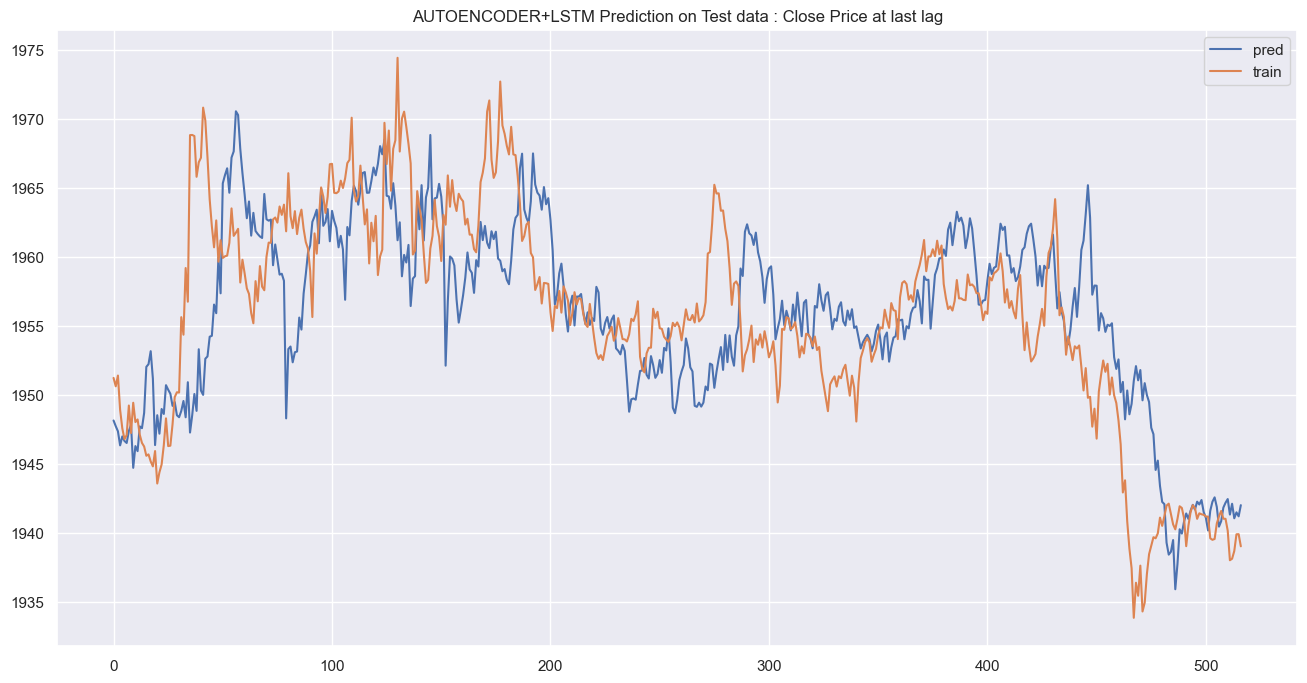

In [142]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [143]:
X_test_sca.shape

(517, 48, 104)

In [144]:
df_feat["Close_ETH"].iloc[-1]

1939.57

In [145]:
df_feat["Close_ETH"].iloc[-1]

1939.57

In [146]:
len(list_i_enc_select)

15

In [147]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1937.61 1934.29 1934.93 1937.   1938.44 1939.04 1939.67 1939.59 1939.95
 1941.09 1940.49 1941.19 1941.96 1942.1  1941.34 1940.6  1940.24 1941.
 1941.91 1941.79 1941.06 1939.02 1940.49 1941.49 1941.99 1941.79 1941.
 1941.4  1941.33 1941.29 1941.17 1941.16 1939.59 1939.48 1939.54 1940.66
 1941.18 1941.57 1941.01 1941.   1940.14 1938.   1938.11 1938.67 1939.88
 1939.89 1939.01 1939.57]
X_last[0,:,0] after divide by price:
[0.99898947 0.99727775 0.99760772 0.99867496 0.9994174  0.99972674
 1.00005156 1.00001031 1.00019592 1.00078368 1.00047433 1.00083524
 1.00123223 1.00130441 1.00091257 1.00053105 1.00034544 1.00073728
 1.00120645 1.00114458 1.00076821 0.99971643 1.00047433 1.00098991
 1.0012477  1.00114458 1.00073728 1.00094351 1.00090742 1.00088679
 1.00082493 1.00081977 1.00001031 0.9999536  0.99998453 1.00056198
 1.00083008 1.00103116 1.00074243 1.00073728 1.00029388 0.99919054
 0.99924726 0.99953598 1.00015983 1.00016499 0.99971128 1.        ]


In [148]:
X_last_encoded_sca.shape

(1, 48, 32)

In [149]:
list_i_enc_select

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]

In [150]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 48, 15)

In [151]:
X_last_sca[:,:,0:4].shape

(1, 48, 4)

In [152]:
X_train_.shape

(52635, 48, 19)

In [153]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53273  1688513100000   1938.11   1939.75  1938.11    1938.67    278.6432   
53274  1688513400000   1938.68   1939.97  1938.67    1939.88    271.2009   
53275  1688513700000   1939.88   1939.99  1939.62    1939.89    230.5695   
53276  1688514000000   1939.89   1939.90  1939.00    1939.01    195.4143   
53277  1688514300000   1939.01   1939.58  1939.00    1939.57     68.3459   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.48712       1725.824627   
1      2023-01-01 00:05:00        1726.48712       1725.824627   
2      2023-01-01 00:10:00        1726.48712       1725.824627   
3      2023-01-01 00:15:00        1726.48712       1725.824627   
4      2023-01-01 00:20:00        1726.48712       1725.824627   
...                    ...               ...               ...   
53273  2023-07-04 23:25:00        1940.21750       1944.555000   
53274  2023-07-04 23:30:00        1940.03500       1944.555000   
53275  2023-07-04 23:35:00        1939.51250       1943.190000   
53276  2023-07-04 23:40:00        1939.23000       1943.140000   
53277  2023-07-04 23:45:00        1938.80250       1943.140000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53273        1939.735  ...         NaN            NaN           NaN   
53274        1939.735  ...         NaN            NaN           NaN   
53275        1939.735  ...         NaN            NaN           NaN   
53276        1939.735  ...         NaN            NaN           NaN   
53277        1939.735  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53273               NaN         0.0               NaN         0.0      0.0   
53274               NaN         0.0               NaN         0.0      0.0   
53275               NaN         0.0               NaN         0.0      0.0   
53276               NaN         0.0               NaN         0.0      0.0   
53277               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53273                  NaN  False  
53274                  NaN  False  
53275                  NaN  False  
53276                  NaN  False  
53277                  NaN  False  

[53278 rows x 136 columns]

In [154]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [155]:
y_last_pred_unscaled

array([[1.0000011 , 0.99997306, 0.9999117 , 0.99986166, 0.999925  ,
        0.99991995, 1.0000225 , 0.99989647, 0.9999403 , 0.9999142 ,
        0.9999419 , 0.99992144, 0.999972  , 0.999992  , 0.9999945 ]],
      dtype=float32)

In [156]:
df_feat["Close_ETH"].iloc[-1]

1939.57

In [157]:
y_last_pred_raw

array([[1939.572 , 1939.5177, 1939.3987, 1939.3016, 1939.4246, 1939.4147,
        1939.6136, 1939.3691, 1939.4541, 1939.4036, 1939.4573, 1939.4176,
        1939.5156, 1939.5544, 1939.5593]], dtype=float32)

In [158]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [159]:
list_pred

[1939.3016,
 1939.4246,
 1939.4147,
 1939.6136,
 1939.3691,
 1939.4541,
 1939.4036,
 1939.4573,
 1939.4176,
 1939.5156,
 1939.5544,
 1939.5593]

In [160]:
save_list(list_pred, path_save_pred_vals)

In [161]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [162]:
list_pred_reload

[1939.3016,
 1939.4246,
 1939.4147,
 1939.6136,
 1939.3691,
 1939.4541,
 1939.4036,
 1939.4573,
 1939.4176,
 1939.5156,
 1939.5544,
 1939.5593]